In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

In [ ]:
(x_train,y_train),(_,_) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


0


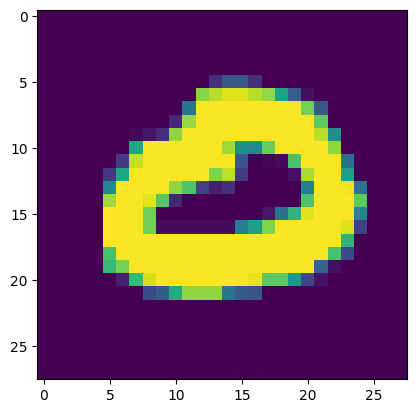

In [ ]:
i = np.random.randint(0,60000)
print(y_train[i])
plt.imshow(x_train[i])

In [ ]:
#adding color channel dimention

x_train = x_train.reshape(x_train.shape[0],28,28,1).astype('float32')

In [ ]:
#normalize

x_train =(x_train - 127.5)/127.5 # from -1 to 1

In [ ]:
buffer_size = 60000
batch_size = 256
#send images in batches , adjust weightes after each batch
#here we use mini batch Grad Desc

In [ ]:
x_train = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

Building the generator

In [ ]:
def generator():
  network = tf.keras.Sequential()

  network.add(layers.Dense(7*7*256,use_bias = False,input_shape=(100, ))) # num is from doc
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))
  # as we are working with a cnn we did this reshape
  network.add(layers.Conv2DTranspose(128,(5,5),padding = 'same' , use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Conv2DTranspose(64,(5,5),strides= (2,2),padding = 'same' , use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Conv2DTranspose(1,(5,5),strides= (2,2),padding = 'same' , use_bias = False,activation = 'tanh'))
  # values are -1 to 1 so best is tanh
  network.summary()
  return network



In [ ]:
generator_model = generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

In [ ]:
noise_input = tf.random.normal([1,100])

In [ ]:
generated_image = generator_model(noise_input,training = False)


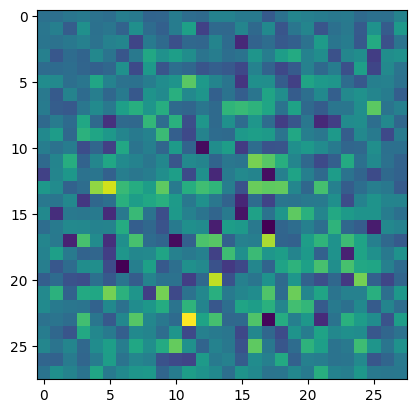

In [ ]:
plt.imshow(generated_image[0])

Discriminator

In [ ]:
def discriminator():
  network = tf.keras.Sequential()

  network.add(layers.Conv2D(64,(5,5),strides = (2,2),padding = 'same',input_shape =[28,28,1] ))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Conv2D(128,(5,5),strides = (2,2),padding = 'same' ))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network


In [ ]:
discriminator_model = discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [ ]:
discriminator_model(generated_image,training = False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00161831]], dtype=float32)>

loss calculation

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [ ]:
def disc_loss(expected_out,fake_out):
  real_loss = cross_entropy(tf.ones_like(expected_out), expected_out)
  fake_loss = cross_entropy(tf.zeros_like(fake_out), fake_out)
  total_loss = real_loss + fake_loss
  return total_loss

In [ ]:
def gen_loss(fake_out):
  return cross_entropy(tf.ones_like(fake_out), fake_out)

In [ ]:
gen_optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001)

start training

In [ ]:
epochs = 100
noise_dim = 100
num_images_to_generate = 16

In [ ]:
@tf.function
def train_steps(images): #recieves real images
  noise = tf.random.normal([batch_size, noise_dim])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator_model(noise, training = True)

    expected_output = discriminator_model(images, training = True)
    fake_output = discriminator_model(generated_images, training = True)

    gen_losses = gen_loss(fake_output)
    disc_losses = disc_loss(expected_output, fake_output)


  #calculate gradients
  gradients_of_generator = gen_tape.gradient(gen_losses, generator_model.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_losses, discriminator_model.trainable_variables)

  #update weights
  #zip: sends two parameters in one varible
  gen_optimizer.apply_gradients(zip(gradients_of_generator, generator_model.trainable_variables))
  disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_model.trainable_variables))

In [ ]:
test_images = tf.random.normal([num_images_to_generate,noise_dim])


In [ ]:
def train(dataset,epochs,test_images):
  for epoch in range(epochs):
    for image_batch in dataset:
      train_steps(image_batch)
    print("epoch finished ->  ",epoch + 1)
    generated_images = generator_model(test_images,training = False)
    #showing the result
    fig = plt.figure(figsize=(10,10))
    for i in range(generated_images.shape[0]):
      plt.subplot(4,4,i+1)
      plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

epoch finished ->   1


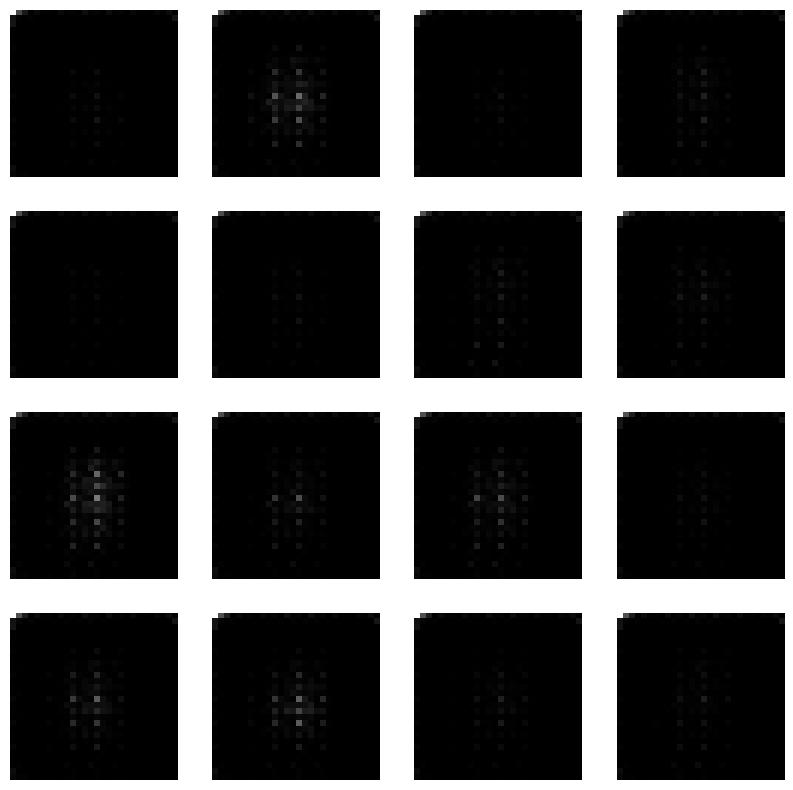

epoch finished ->   2


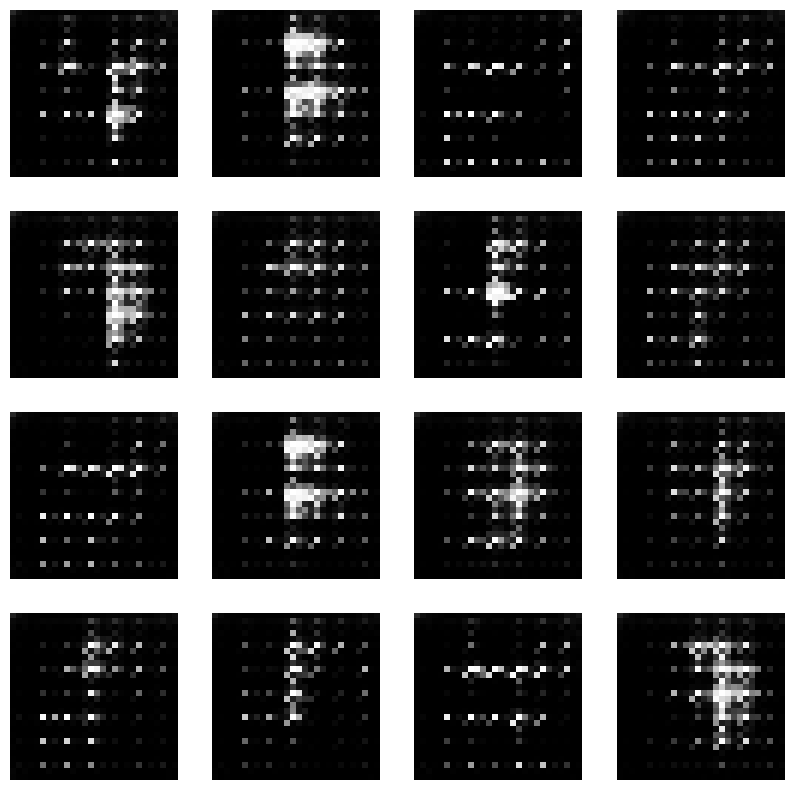

epoch finished ->   3


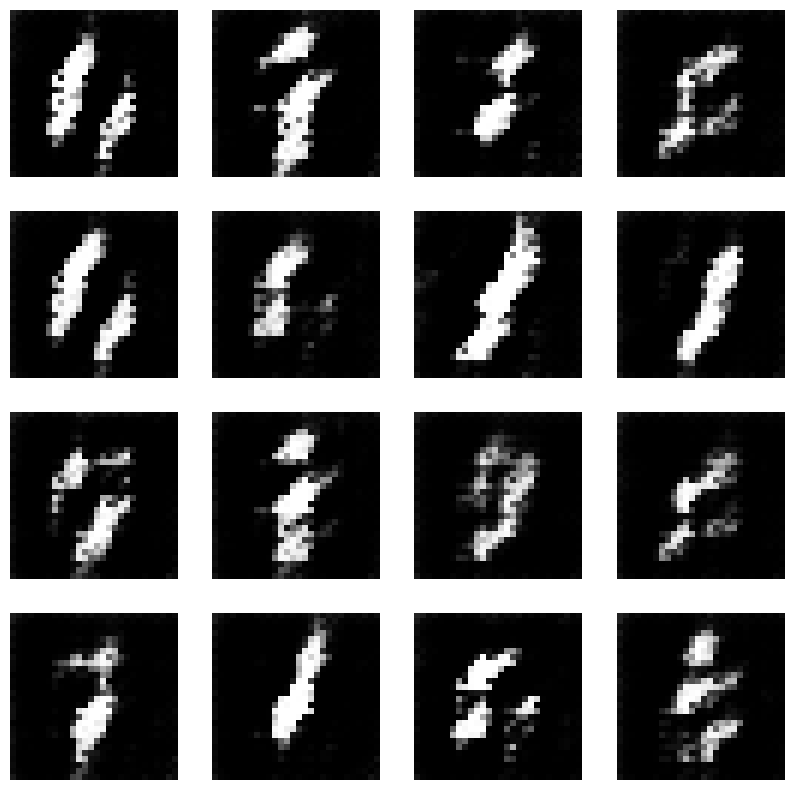

epoch finished ->   4


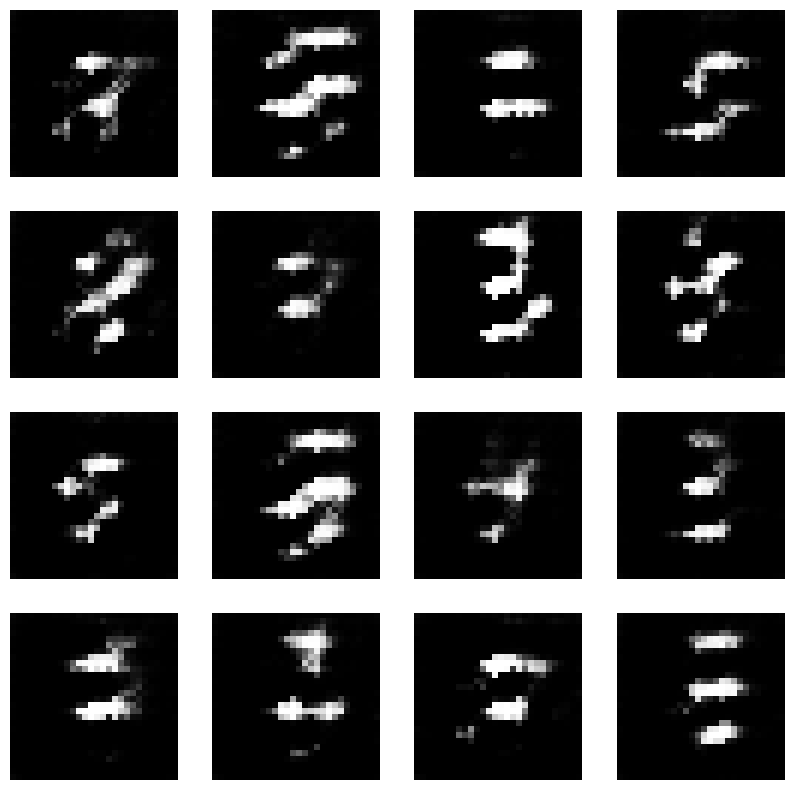

epoch finished ->   5


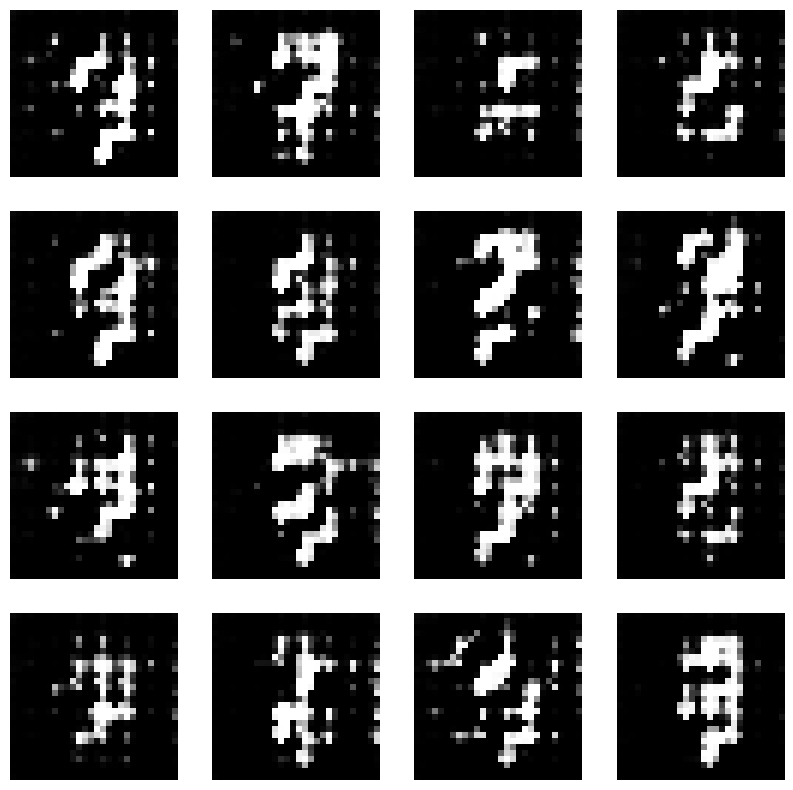

epoch finished ->   6


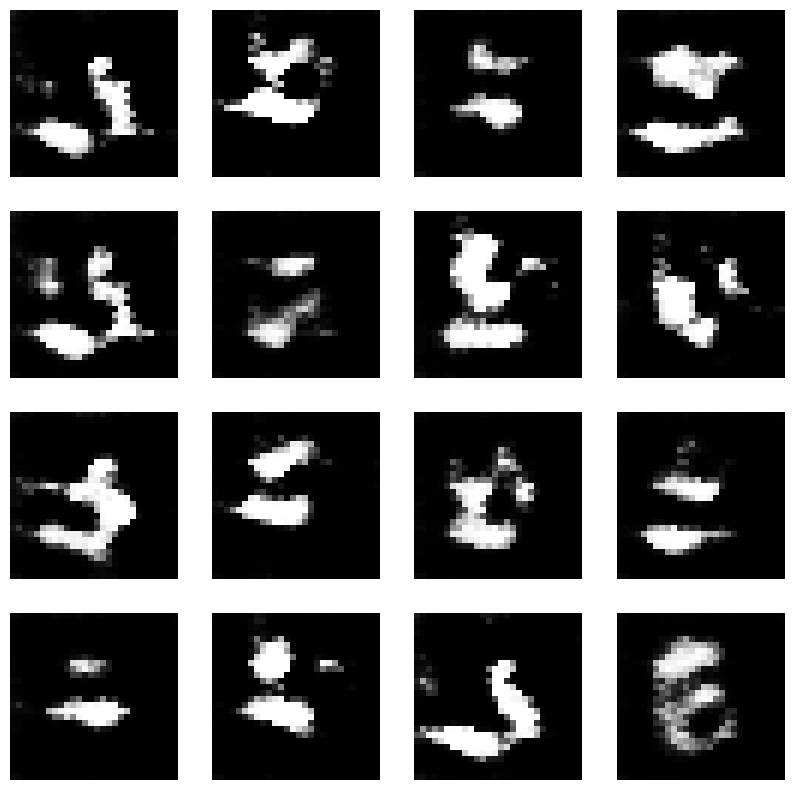

epoch finished ->   7


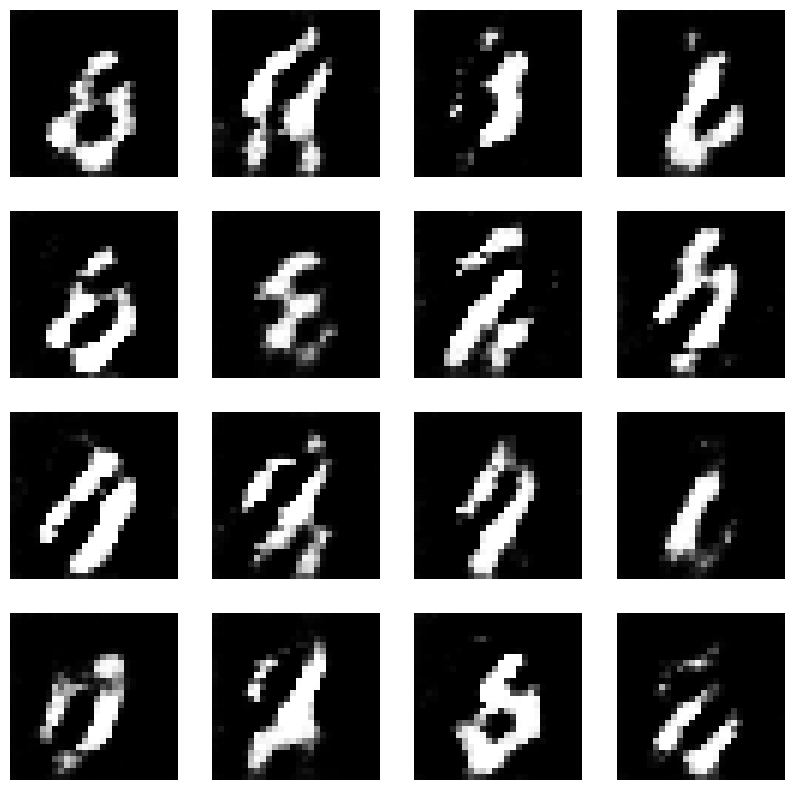

epoch finished ->   8


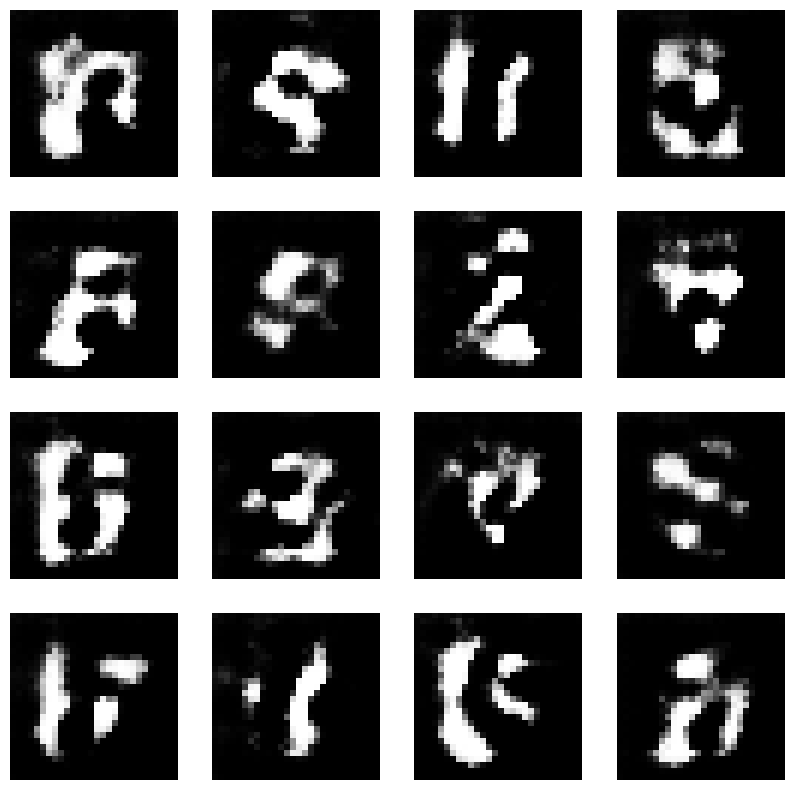

epoch finished ->   9


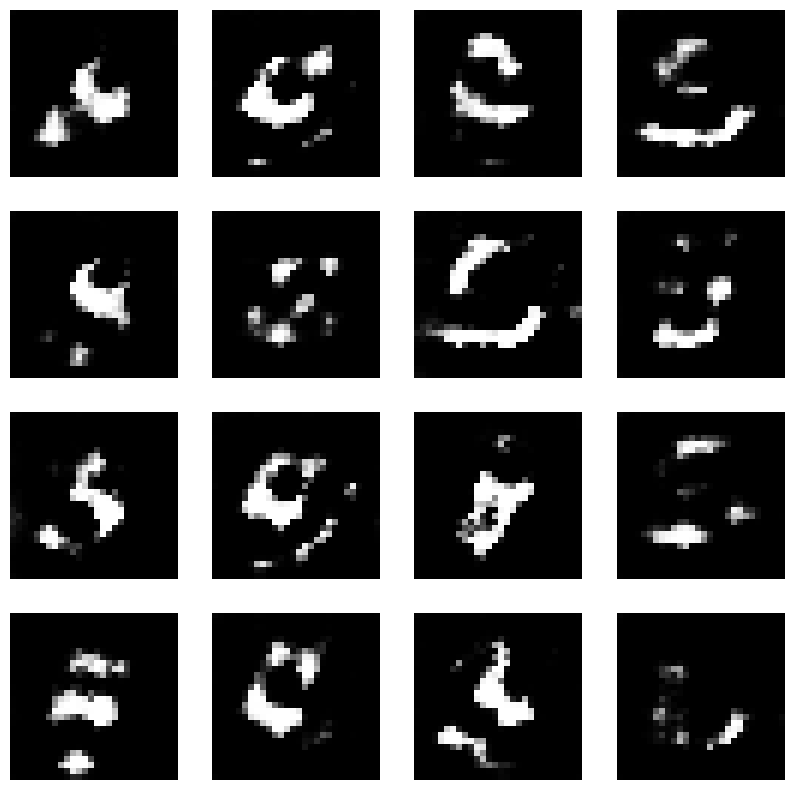

epoch finished ->   10


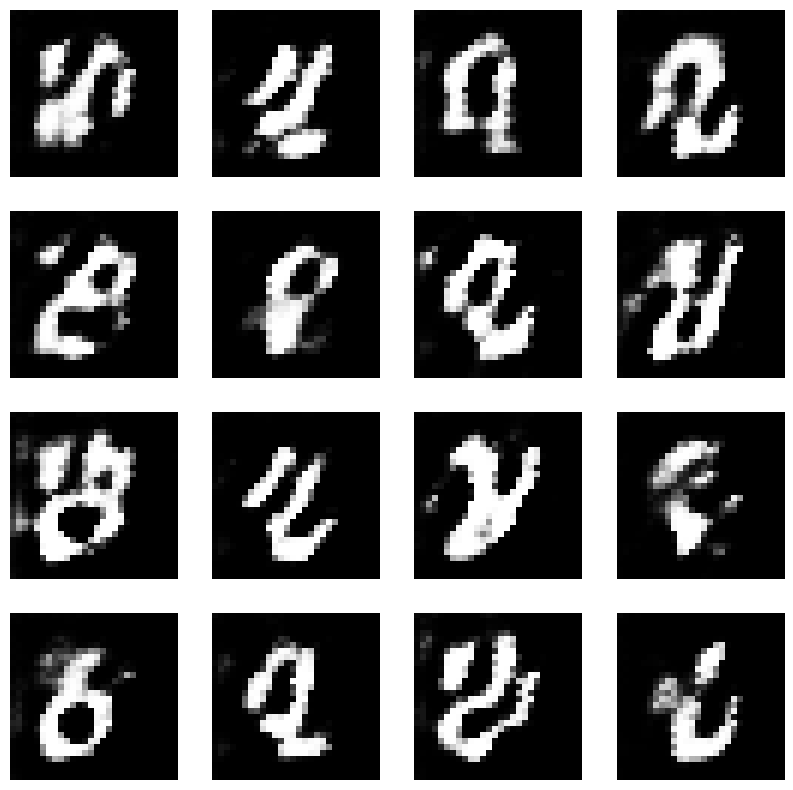

epoch finished ->   11


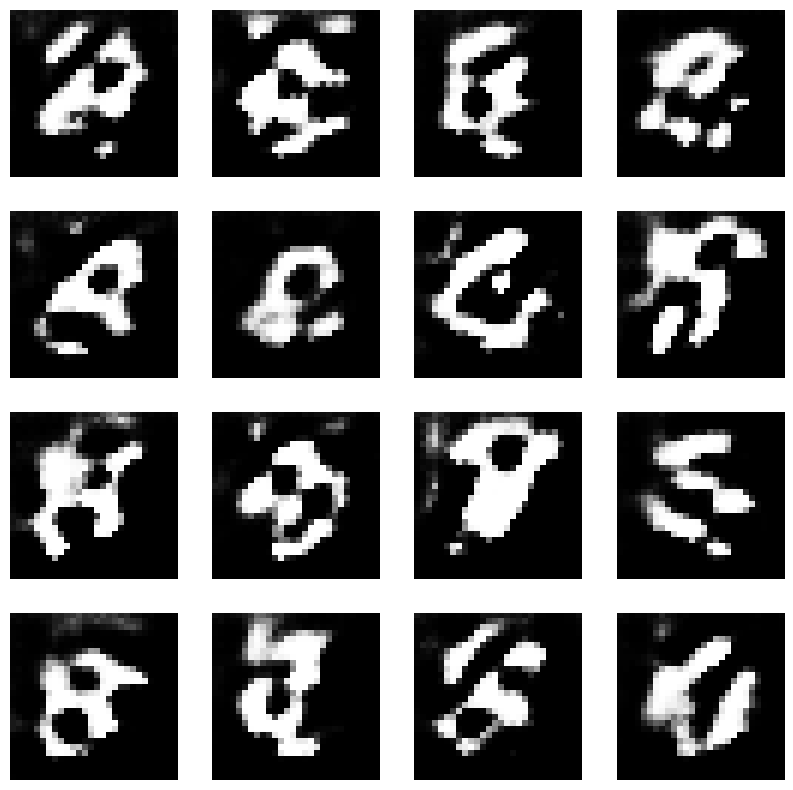

epoch finished ->   12


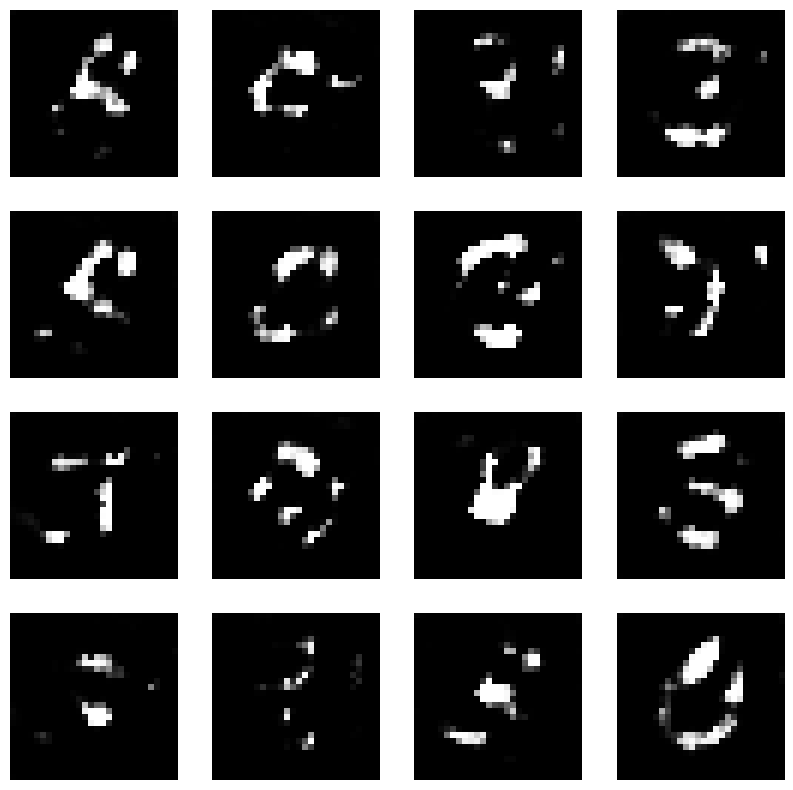

epoch finished ->   13


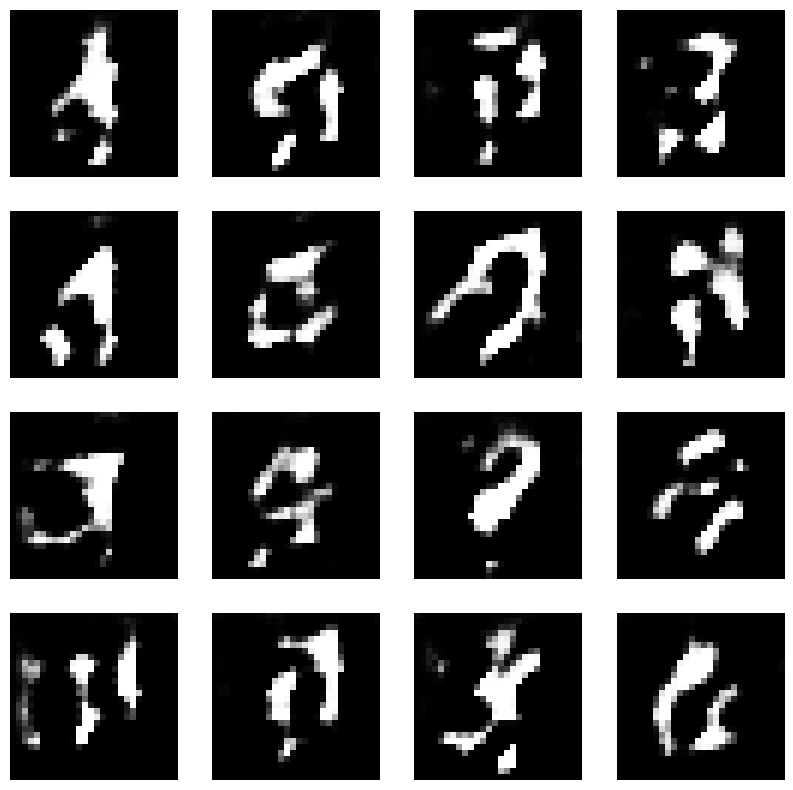

epoch finished ->   14


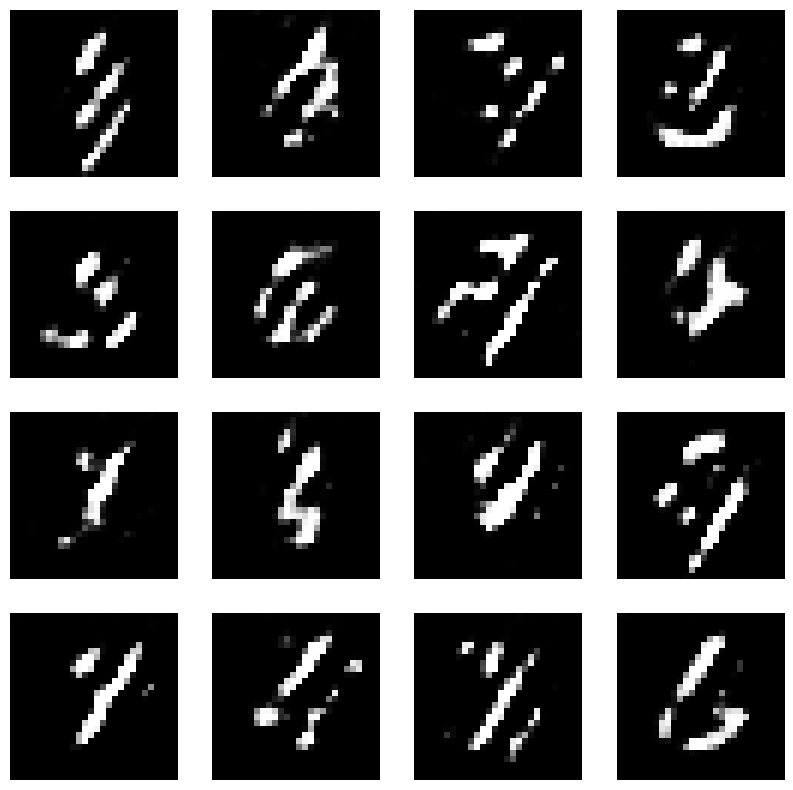

epoch finished ->   15


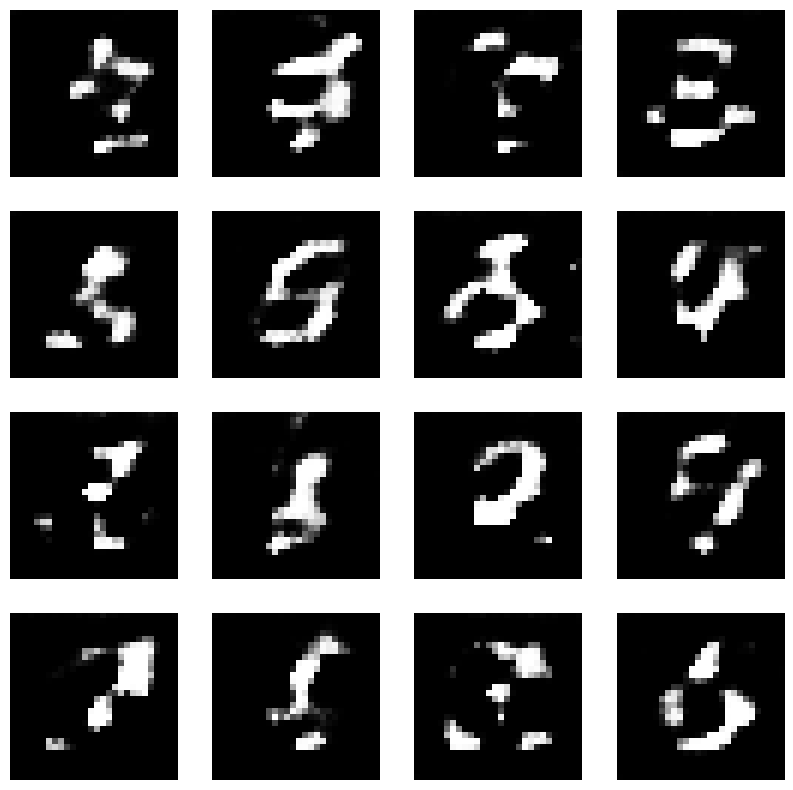

epoch finished ->   16


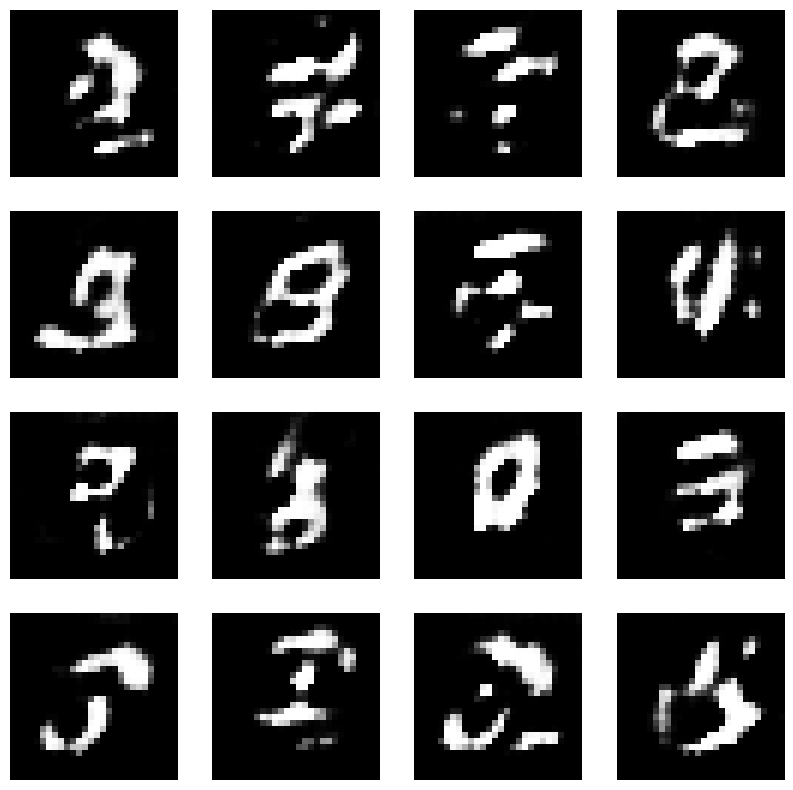

epoch finished ->   17


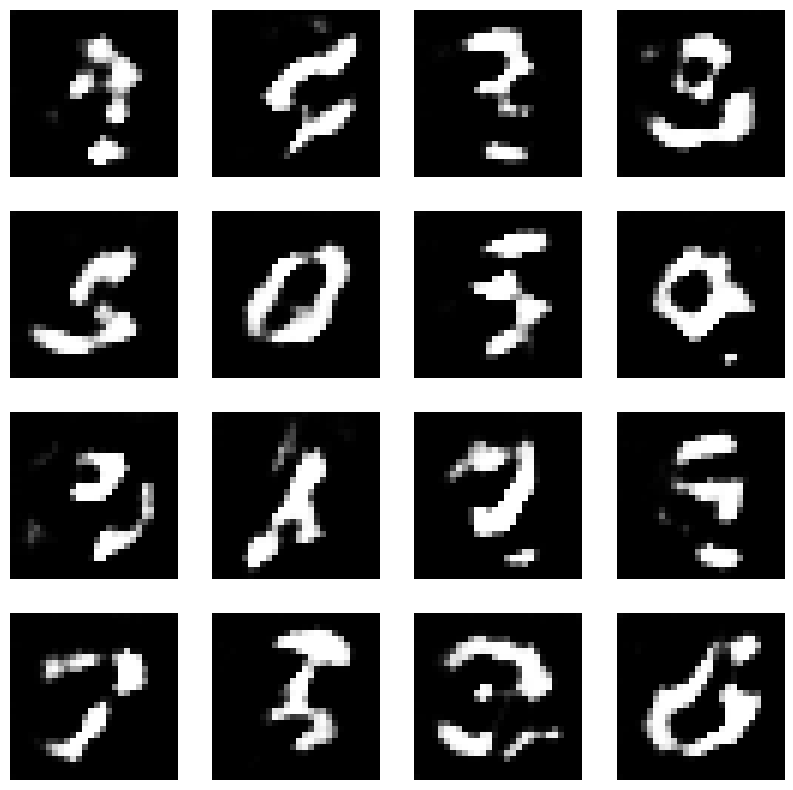

epoch finished ->   18


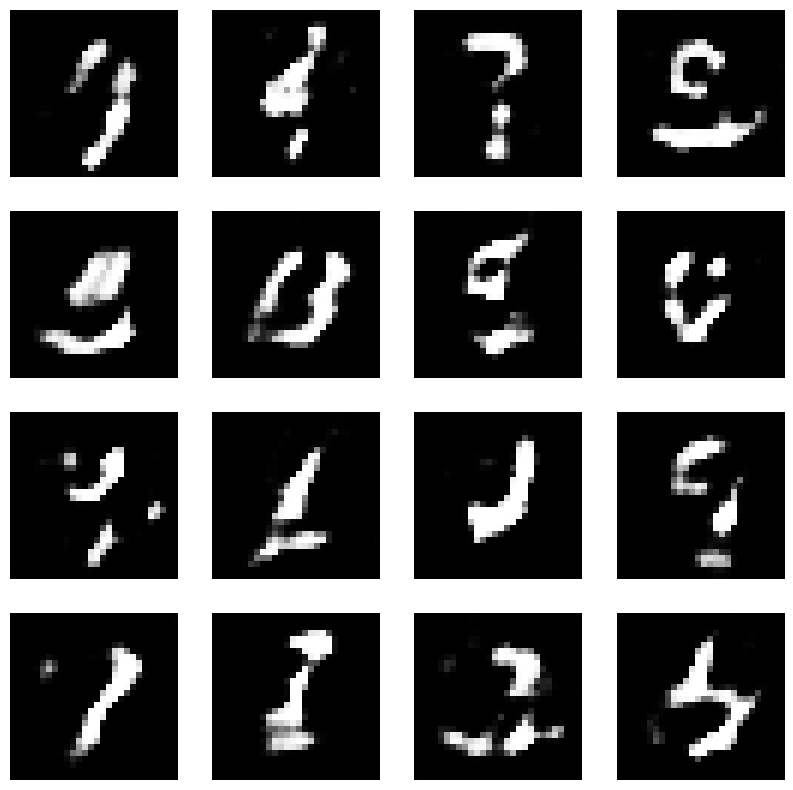

epoch finished ->   19


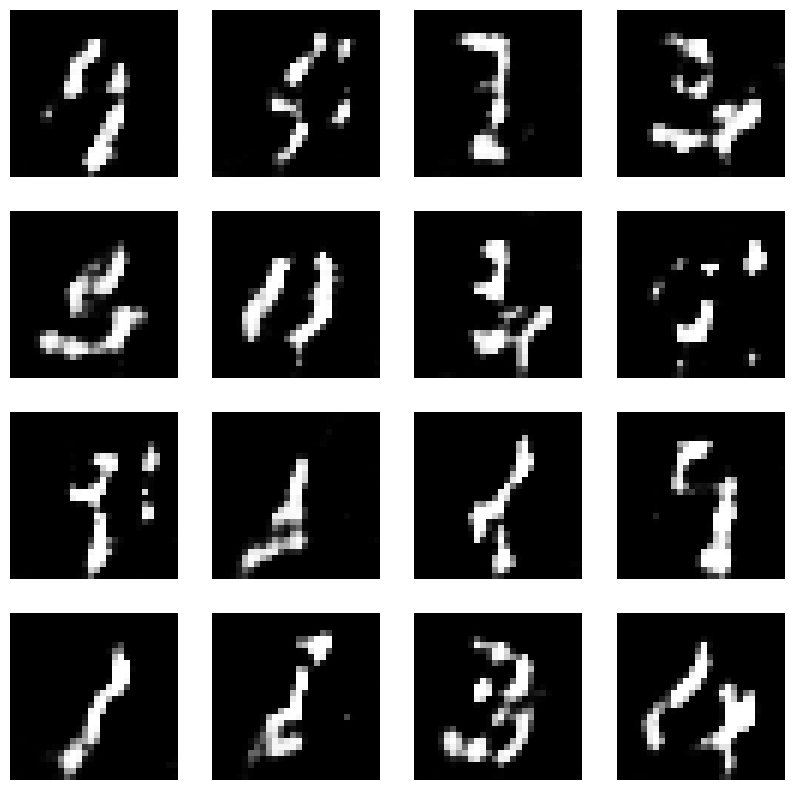

epoch finished ->   20


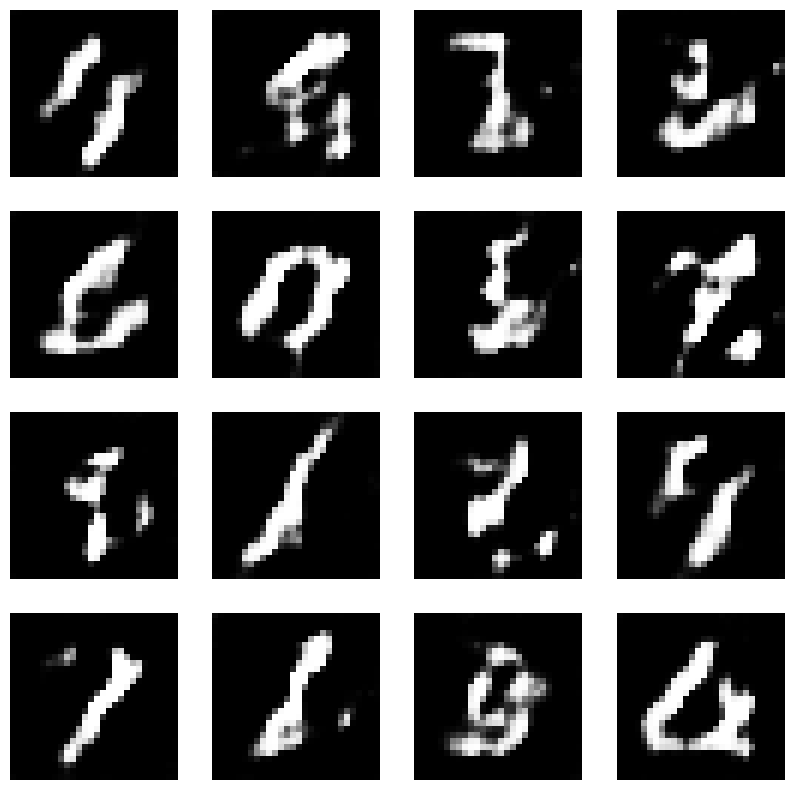

epoch finished ->   21


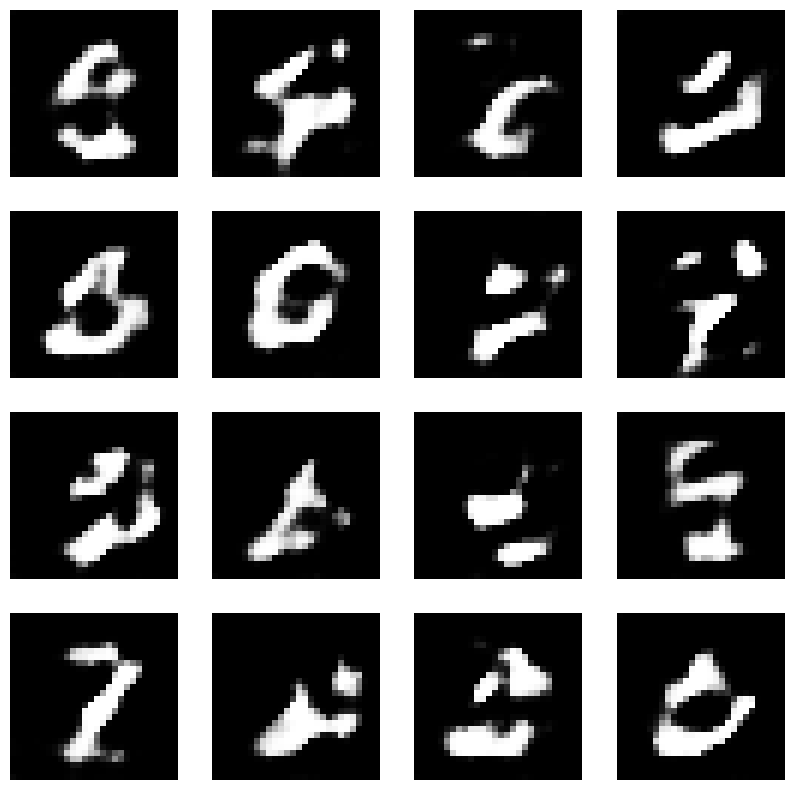

epoch finished ->   22


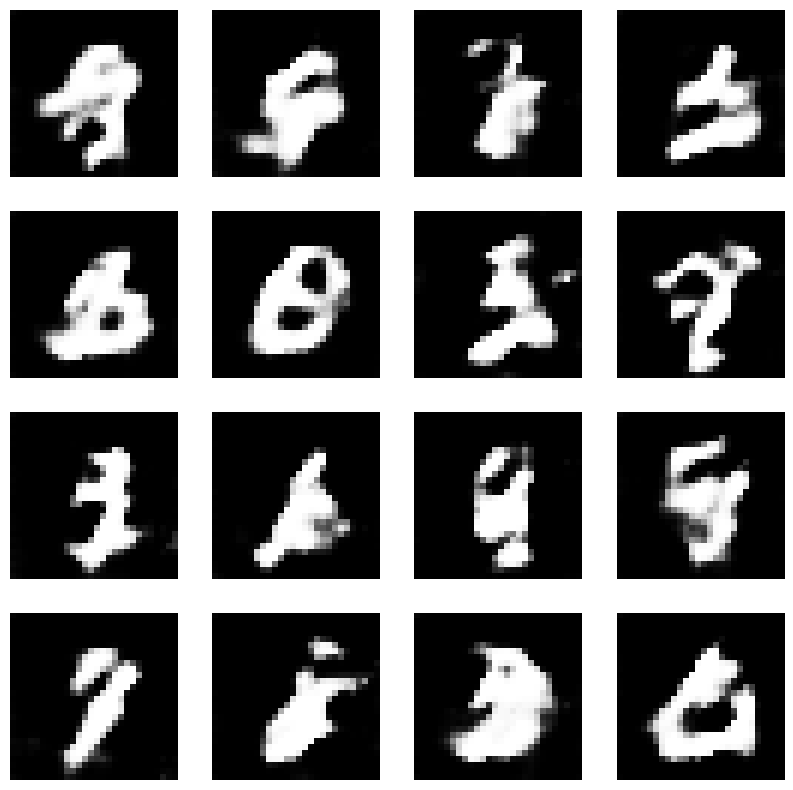

epoch finished ->   23


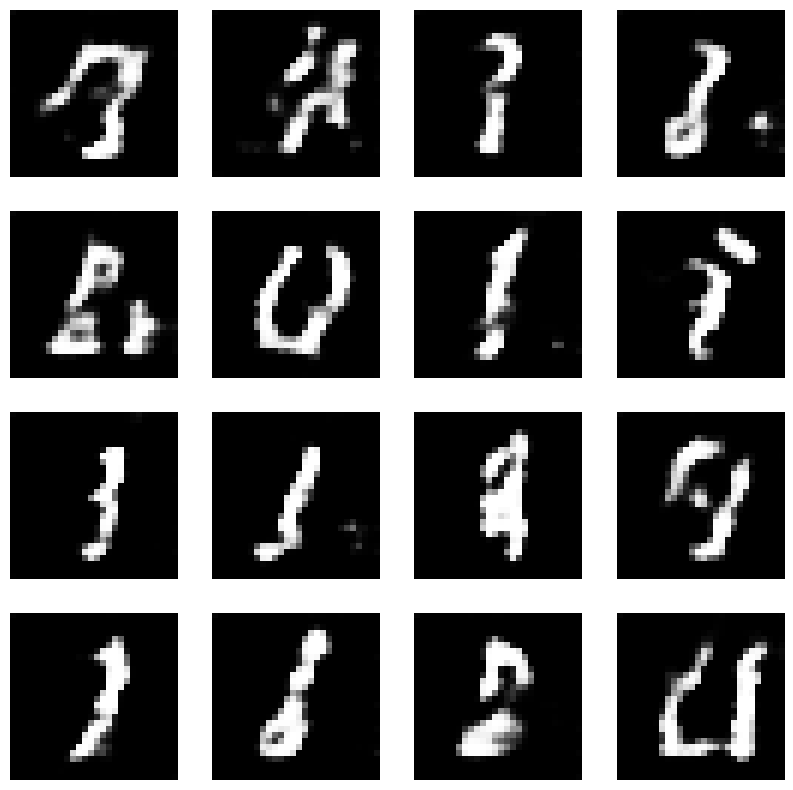

epoch finished ->   24


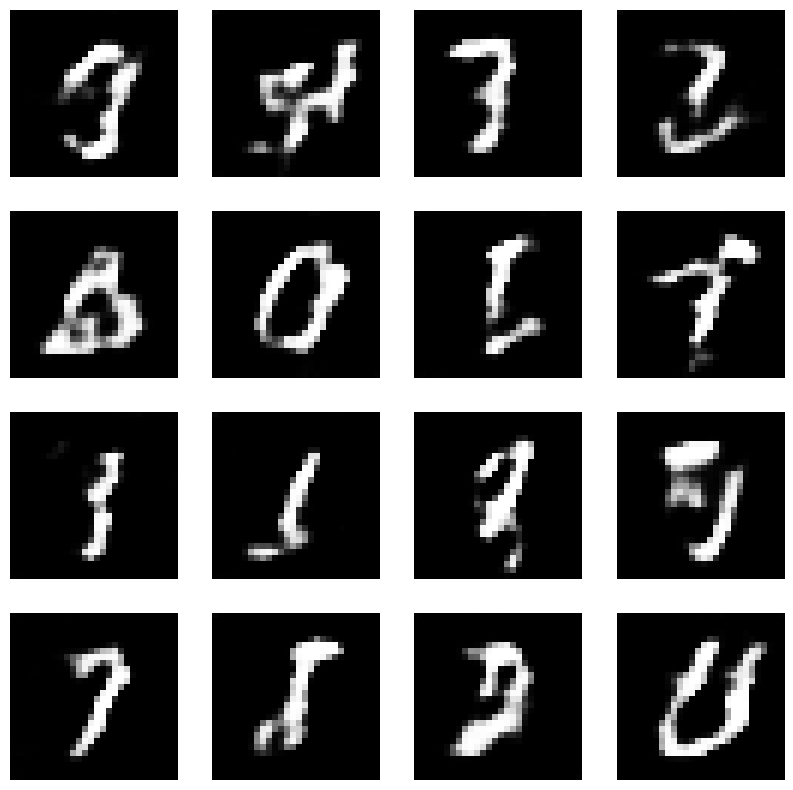

epoch finished ->   25


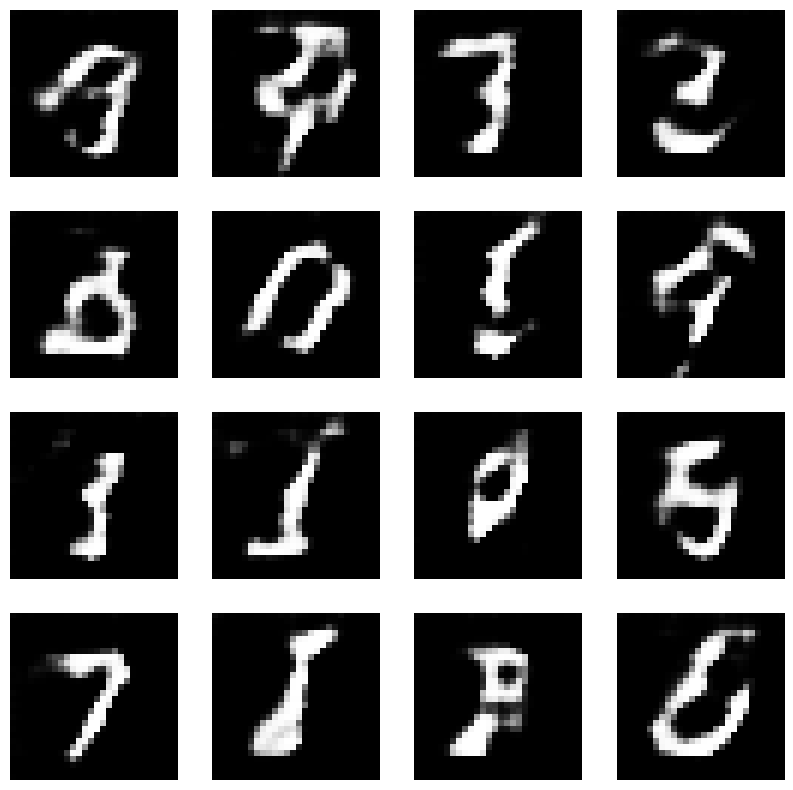

epoch finished ->   26


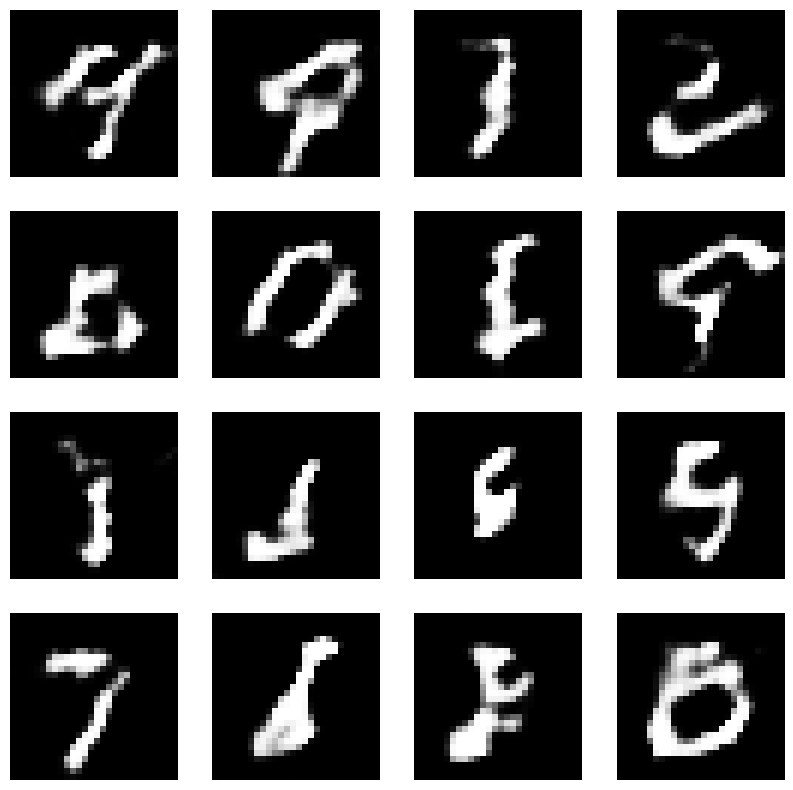

epoch finished ->   27


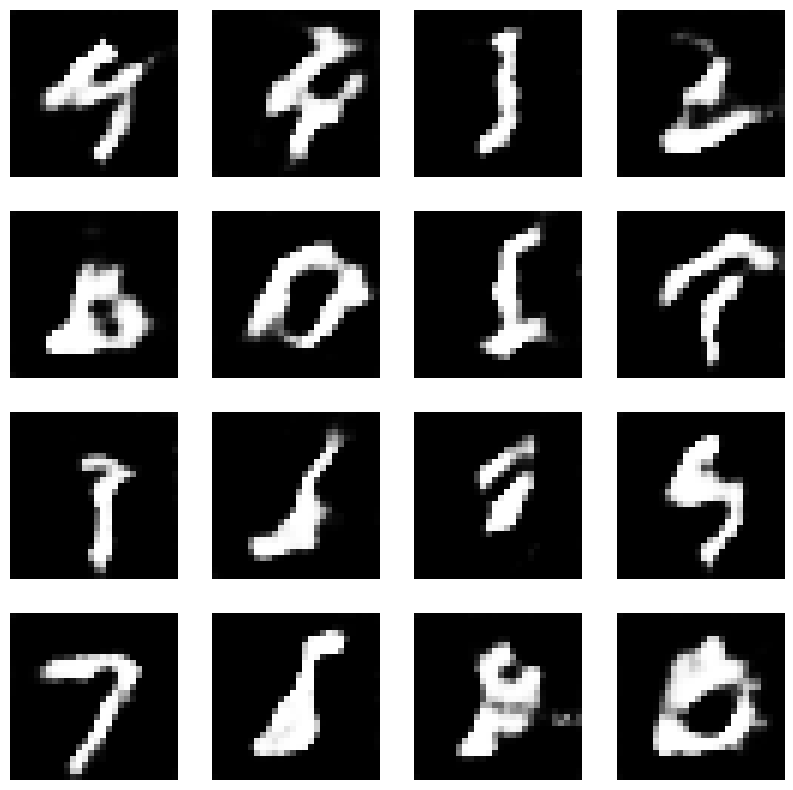

epoch finished ->   28


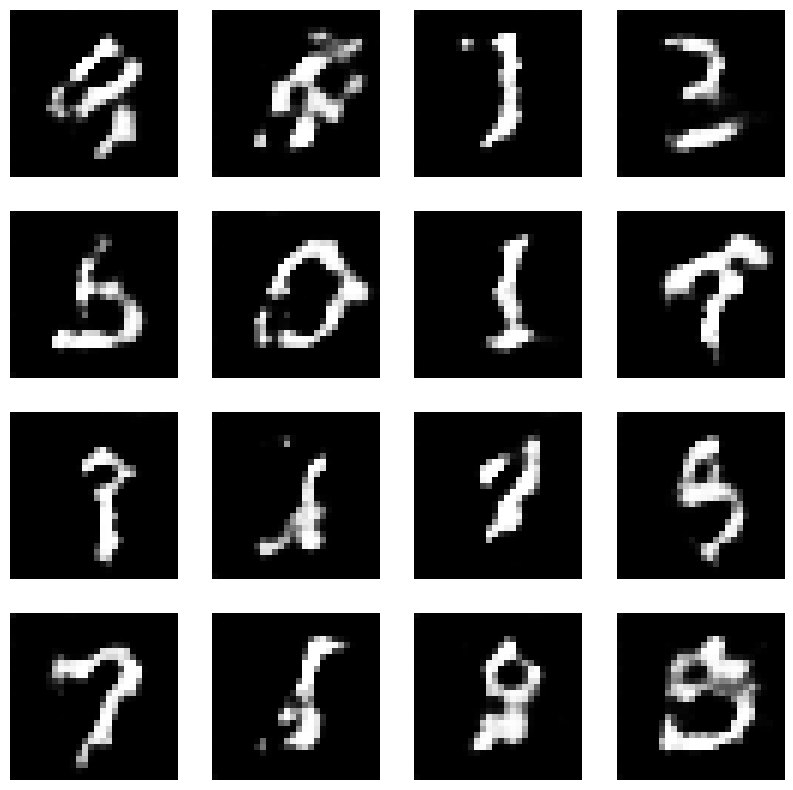

epoch finished ->   29


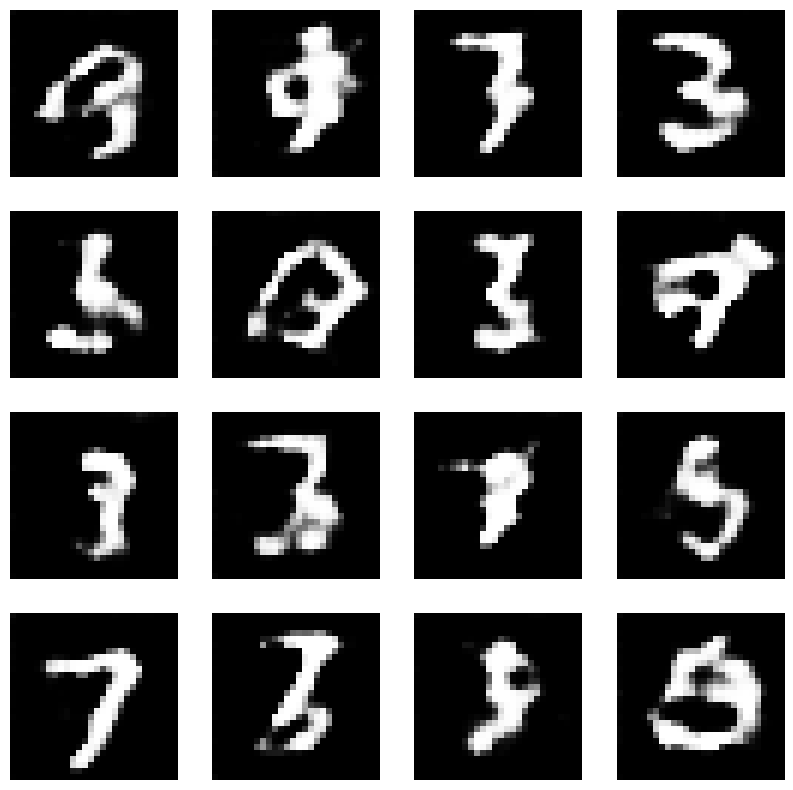

epoch finished ->   30


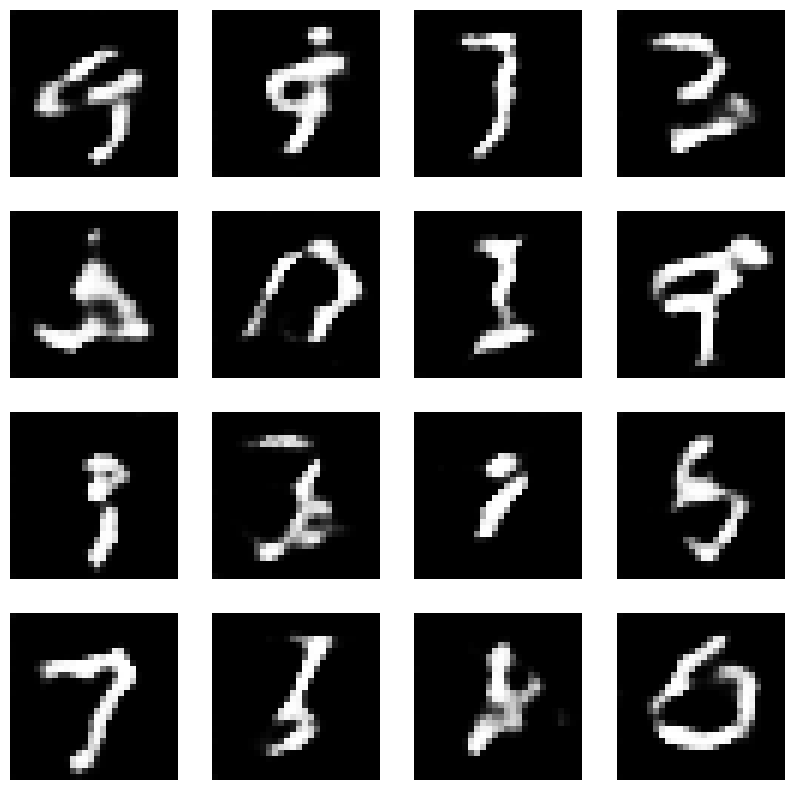

epoch finished ->   31


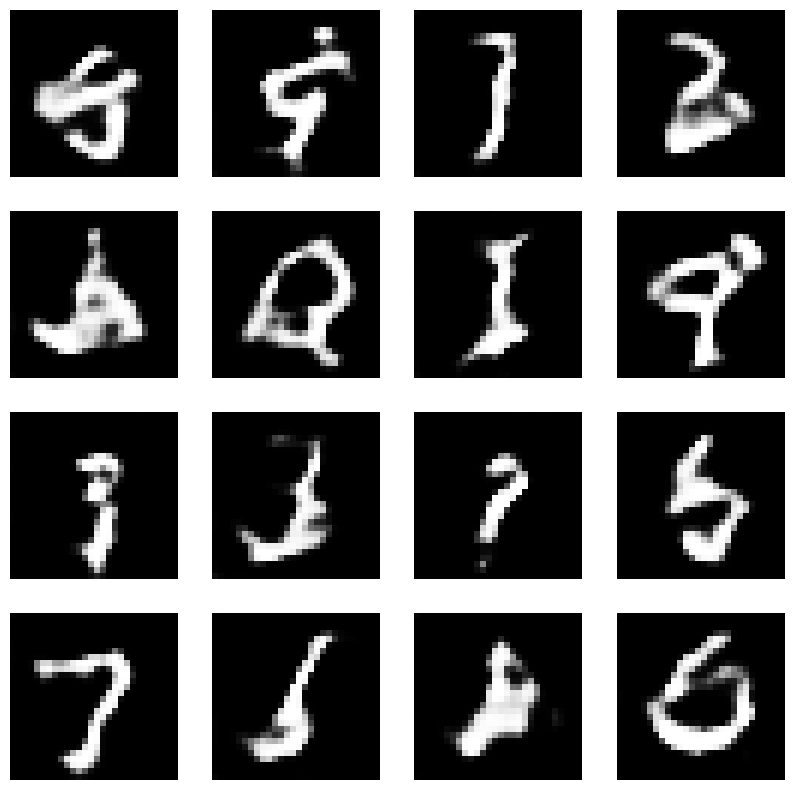

epoch finished ->   32


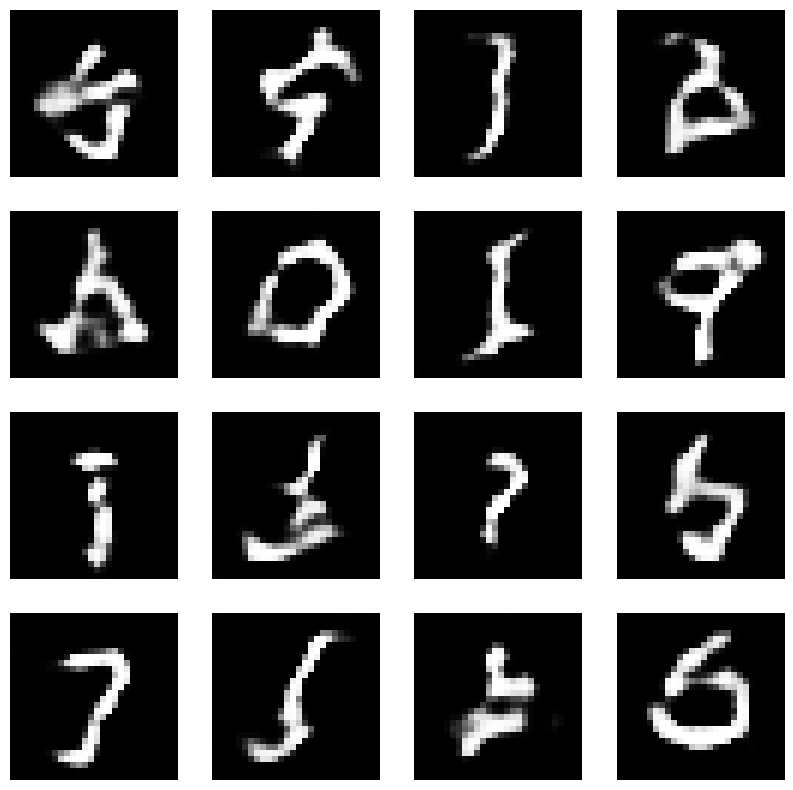

epoch finished ->   33


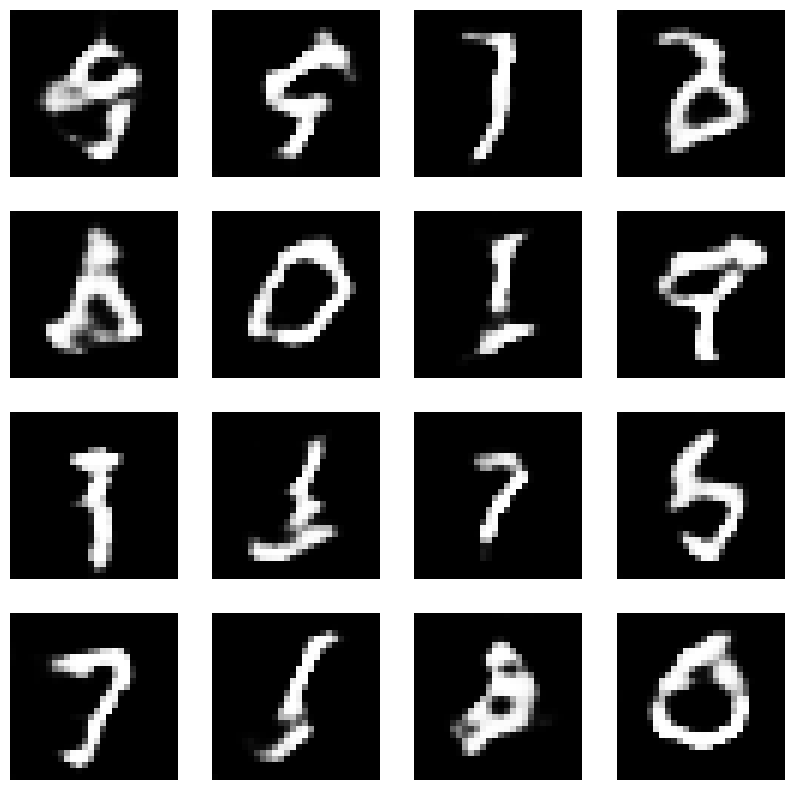

epoch finished ->   34


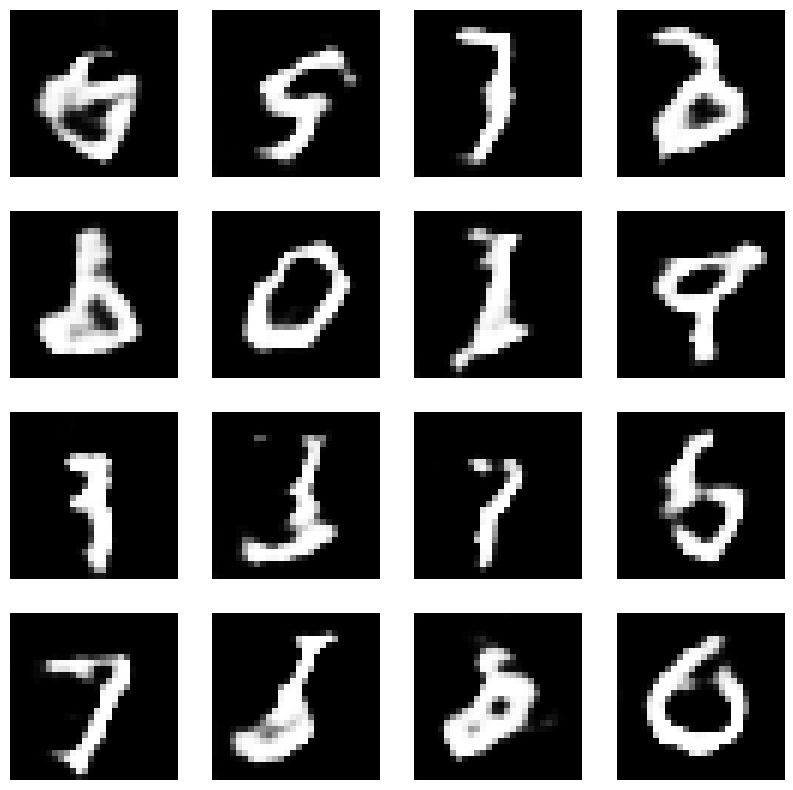

epoch finished ->   35


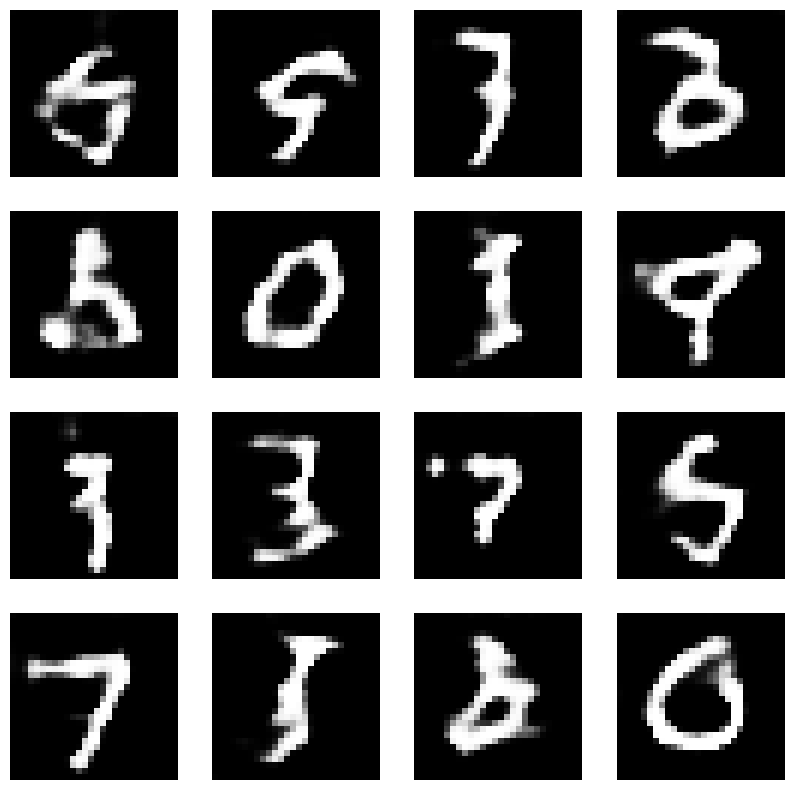

epoch finished ->   36


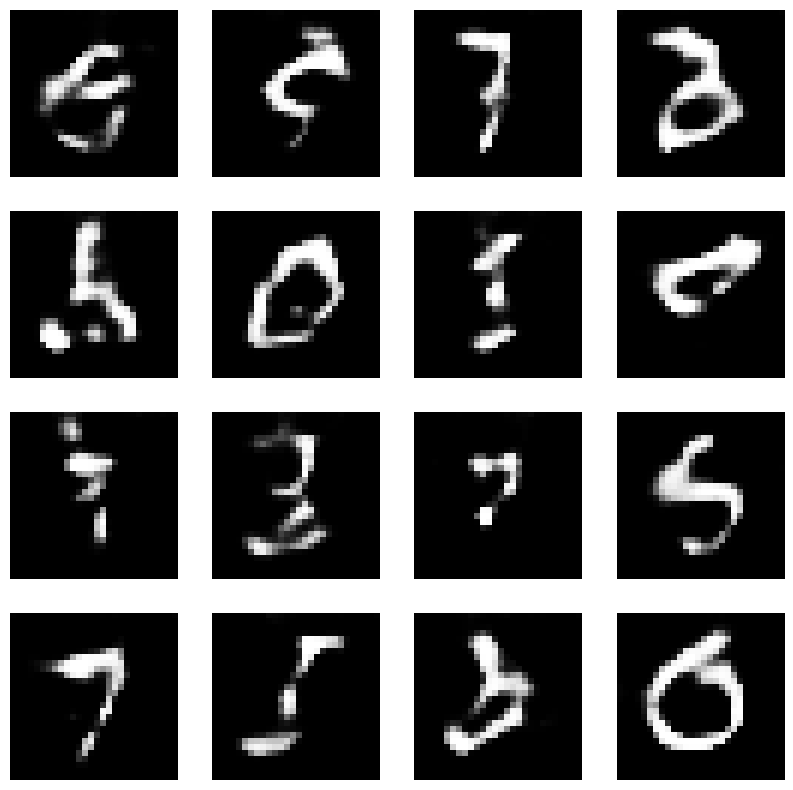

epoch finished ->   37


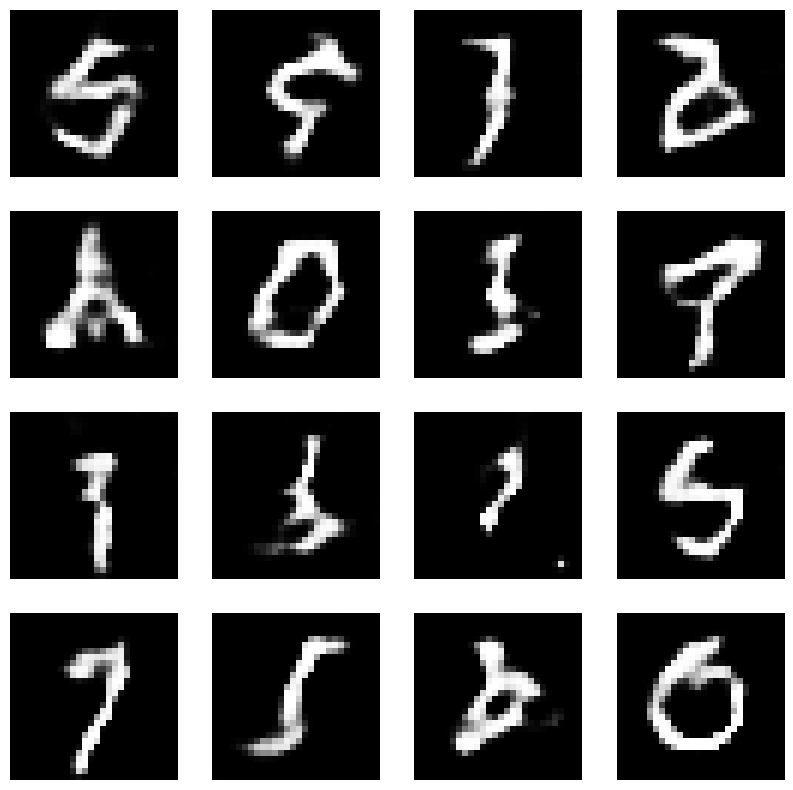

epoch finished ->   38


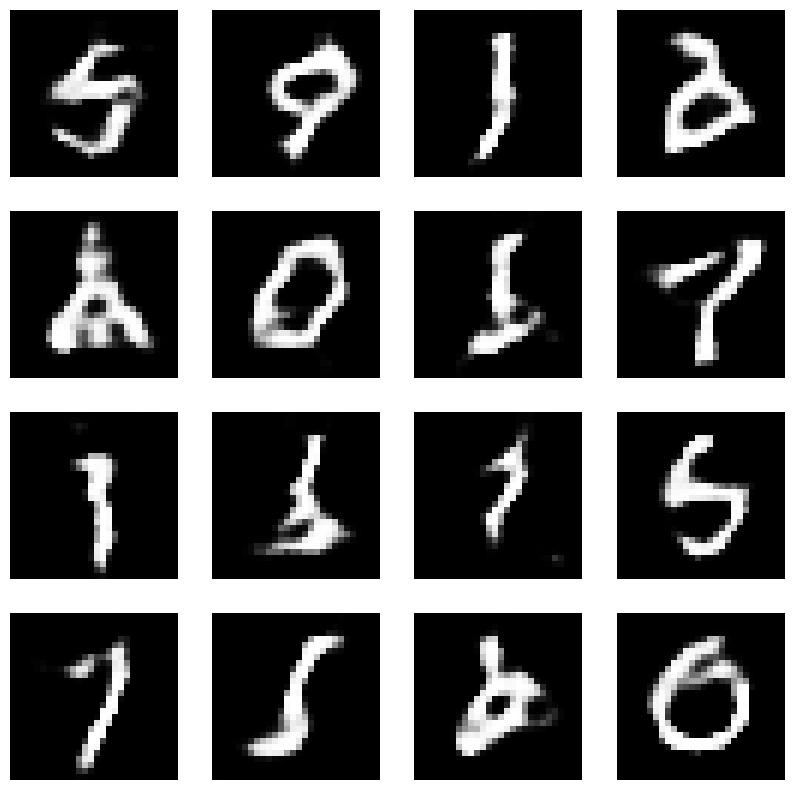

epoch finished ->   39


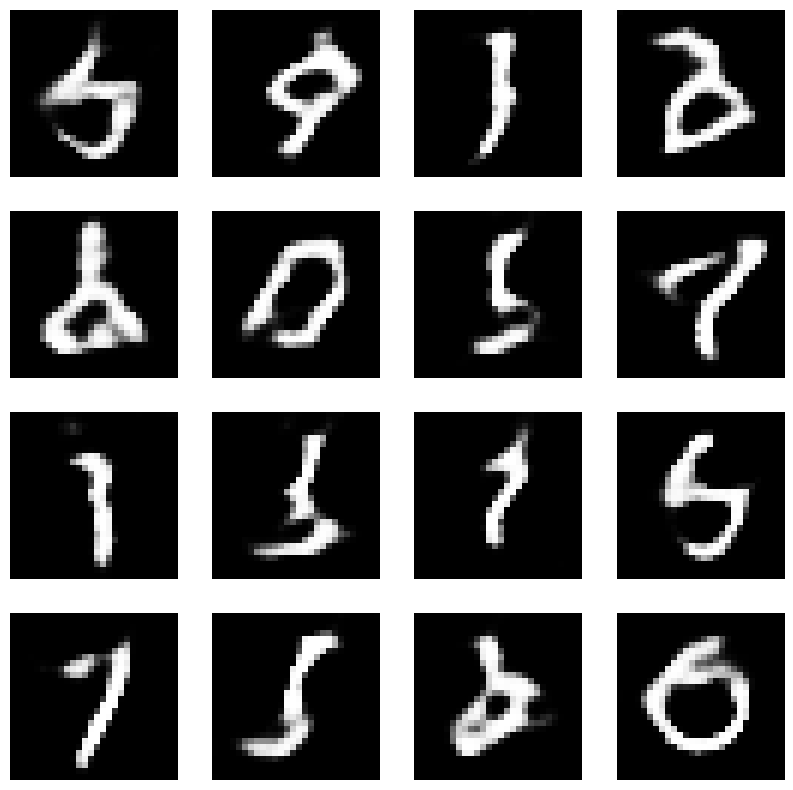

epoch finished ->   40


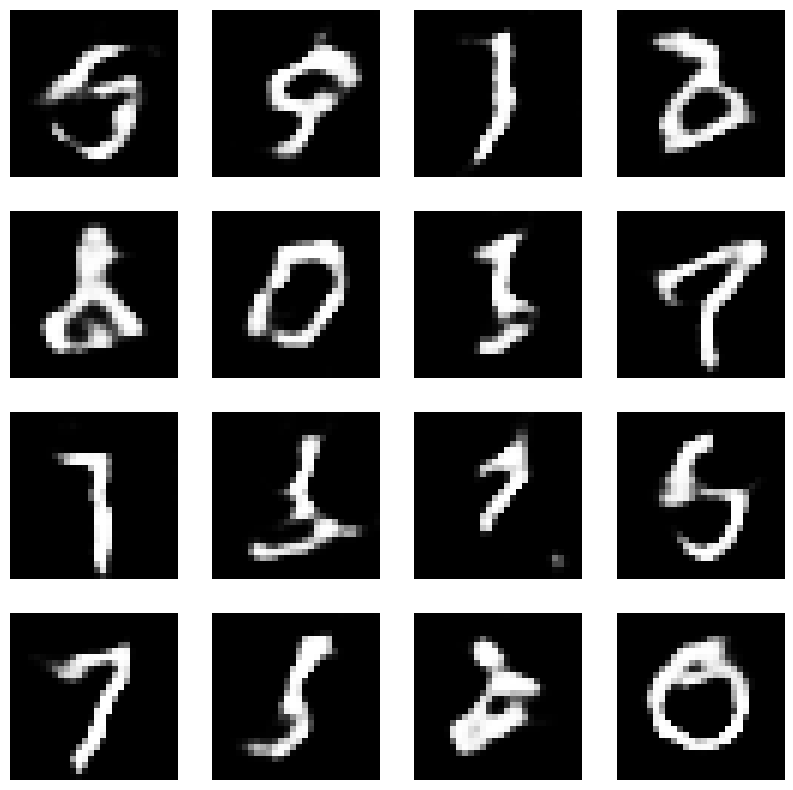

epoch finished ->   41


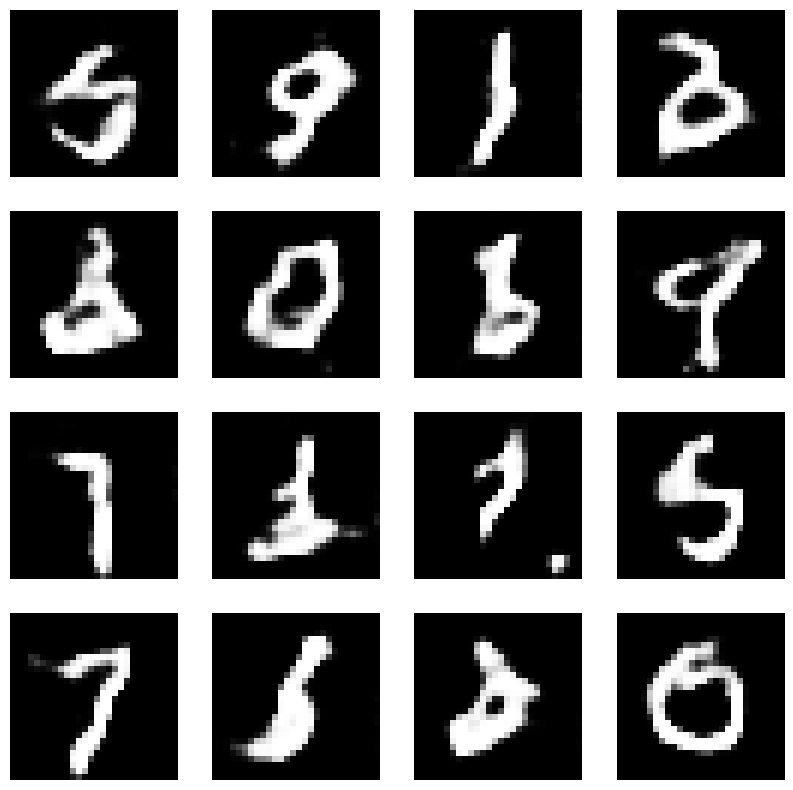

epoch finished ->   42


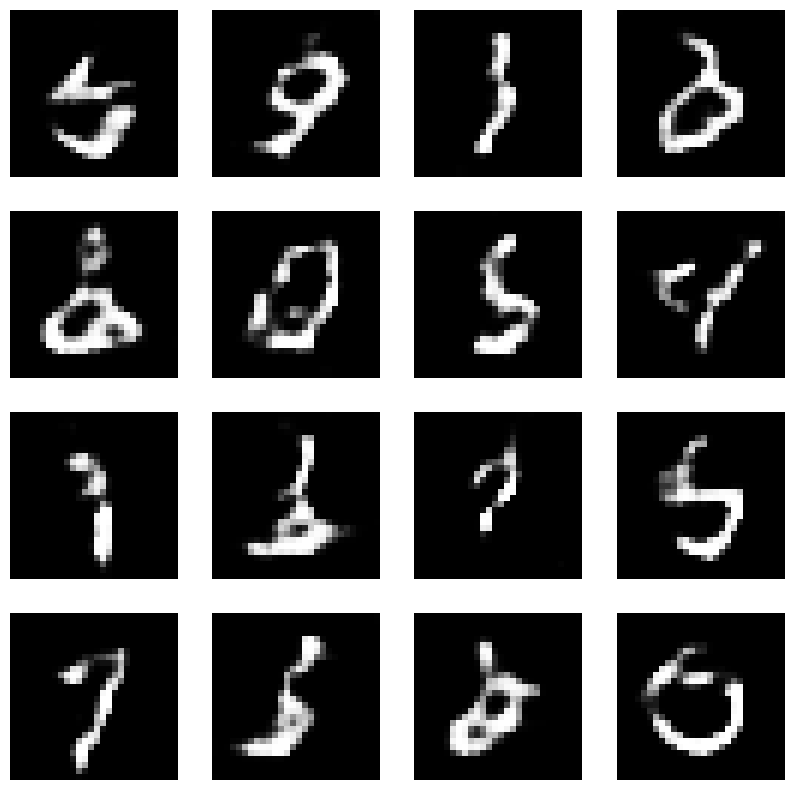

epoch finished ->   43


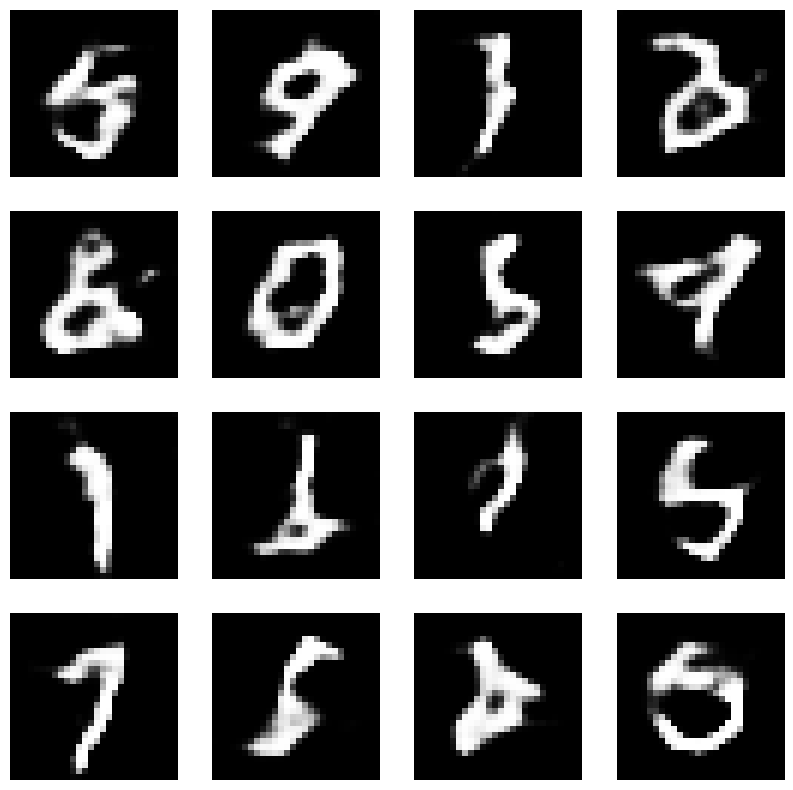

epoch finished ->   44


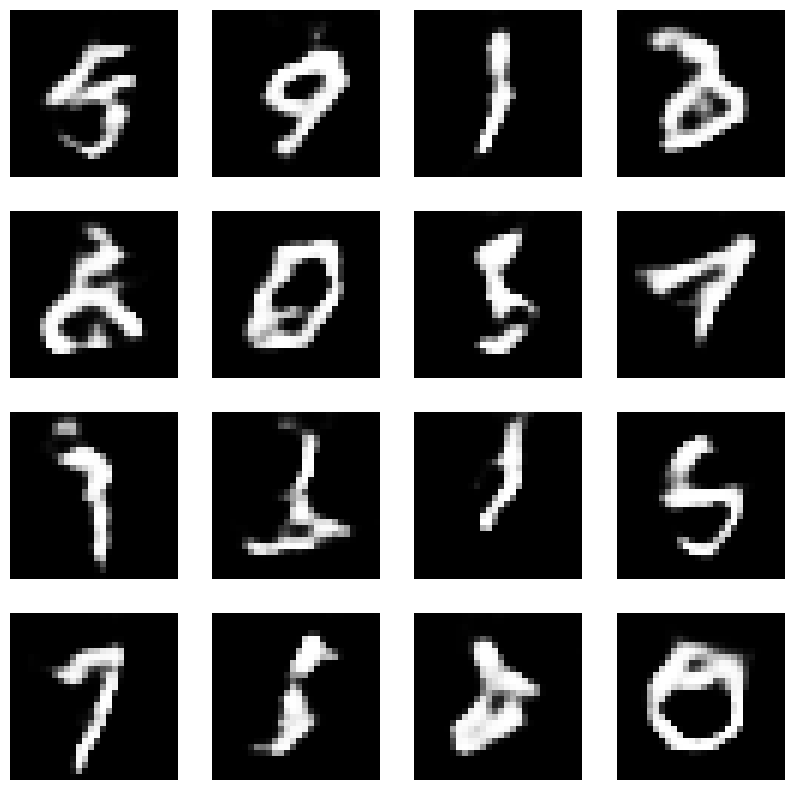

epoch finished ->   45


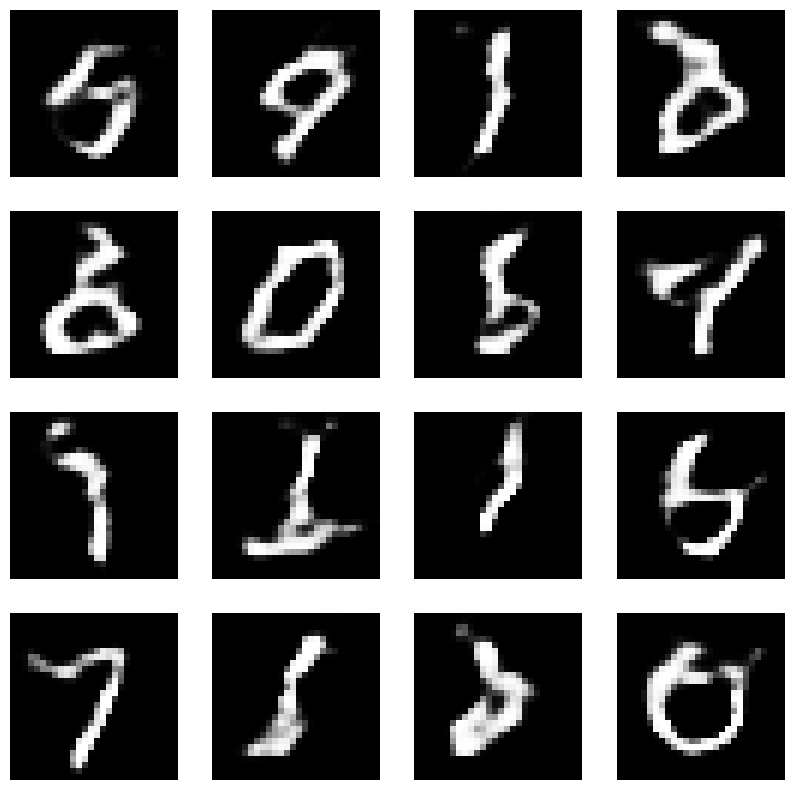

epoch finished ->   46


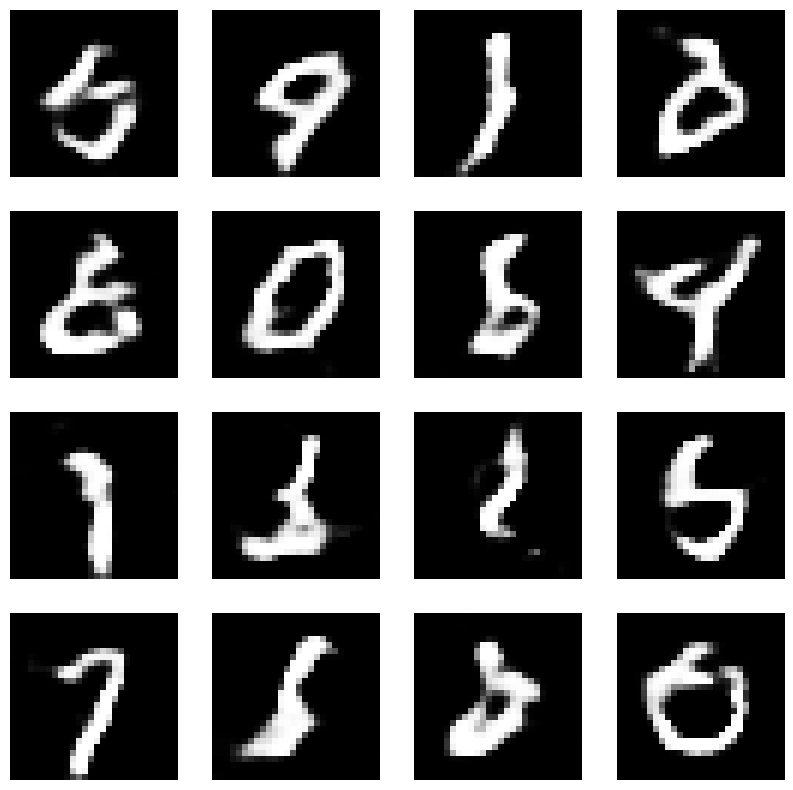

epoch finished ->   47


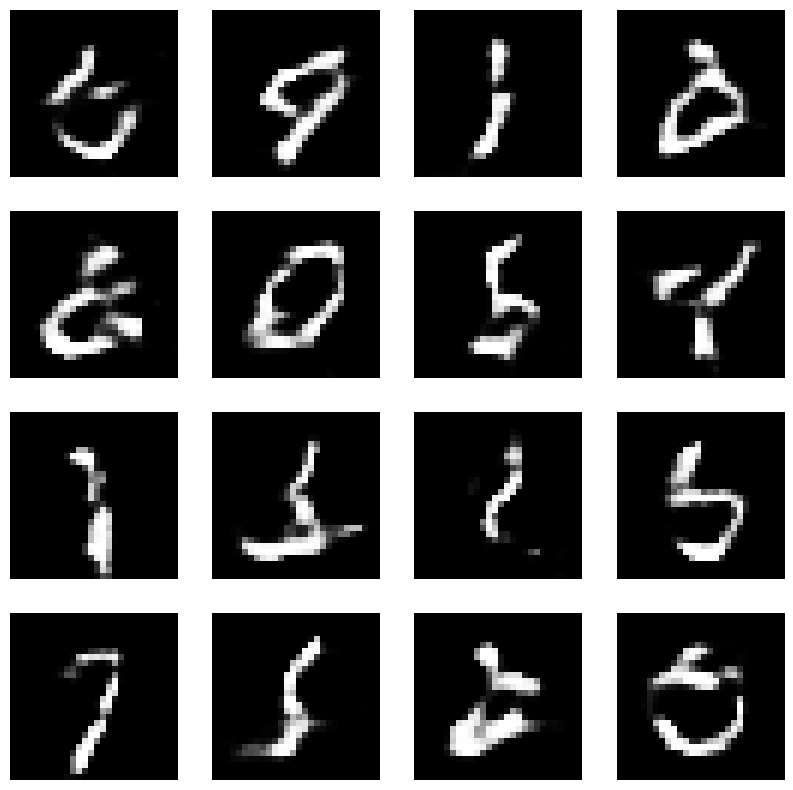

epoch finished ->   48


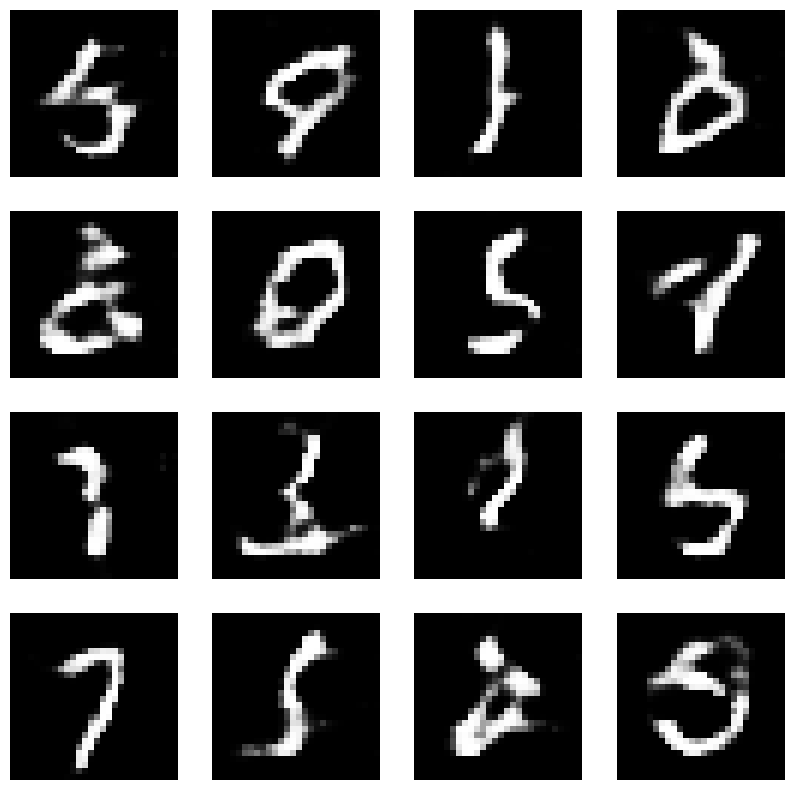

epoch finished ->   49


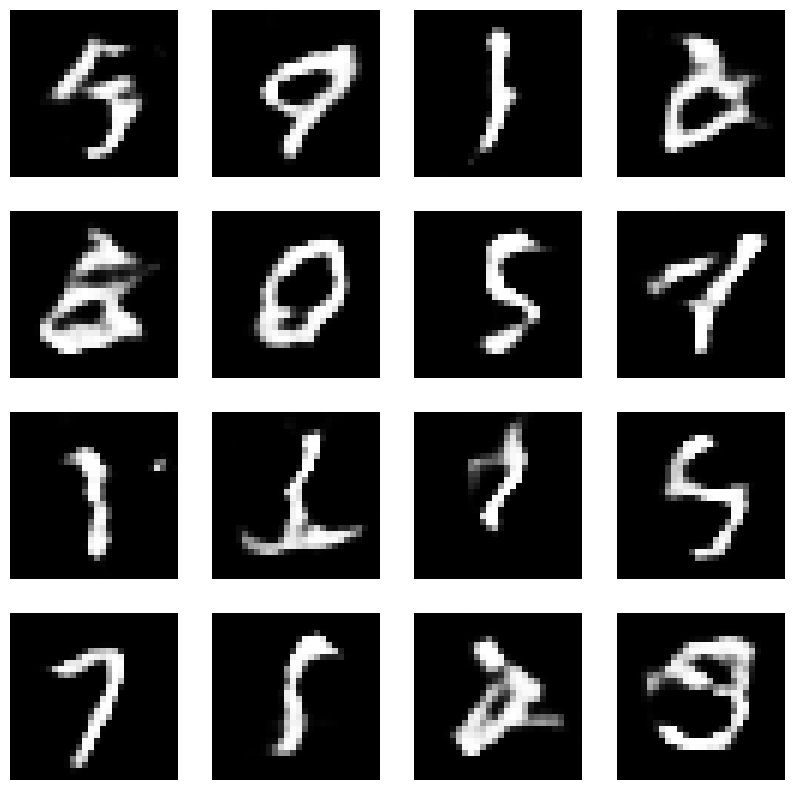

epoch finished ->   50


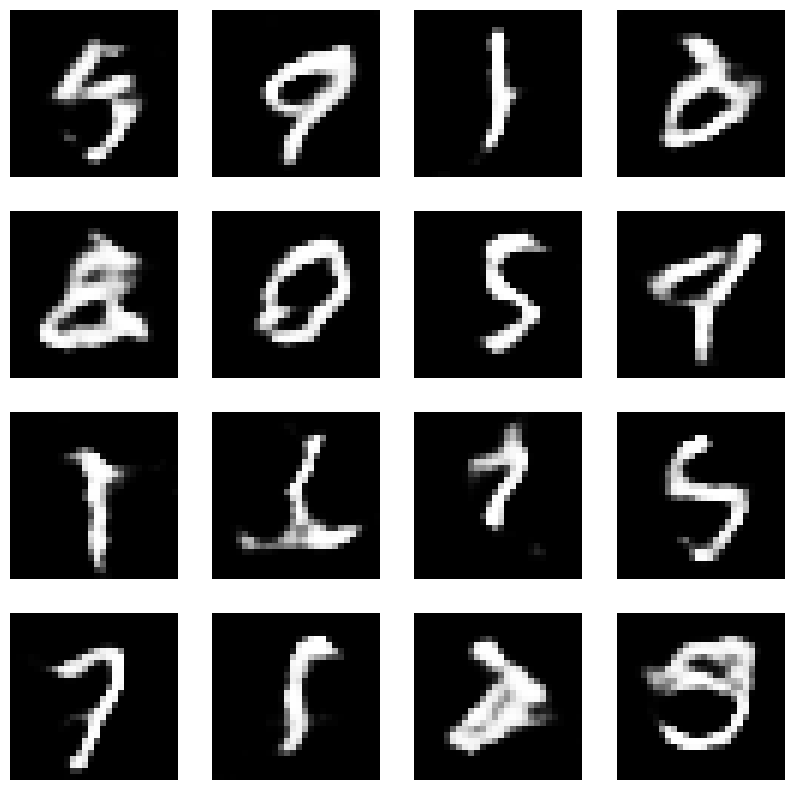

epoch finished ->   51


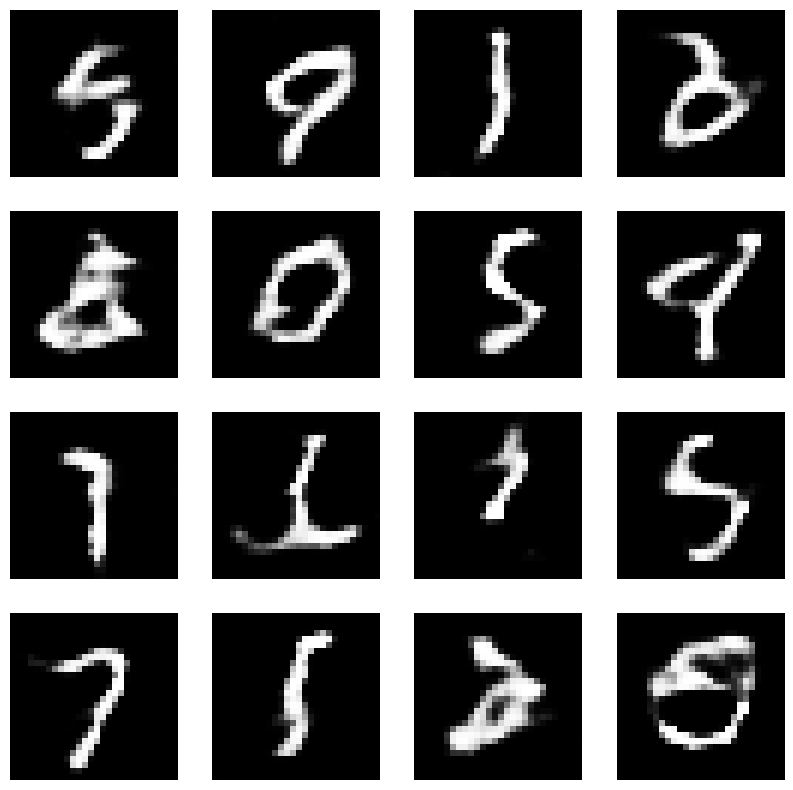

epoch finished ->   52


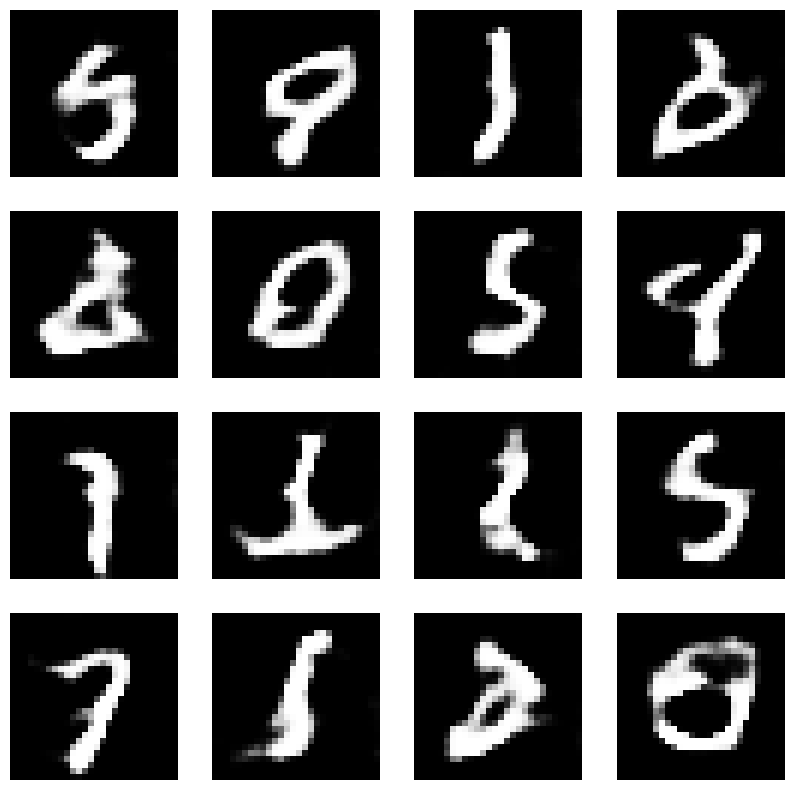

epoch finished ->   53


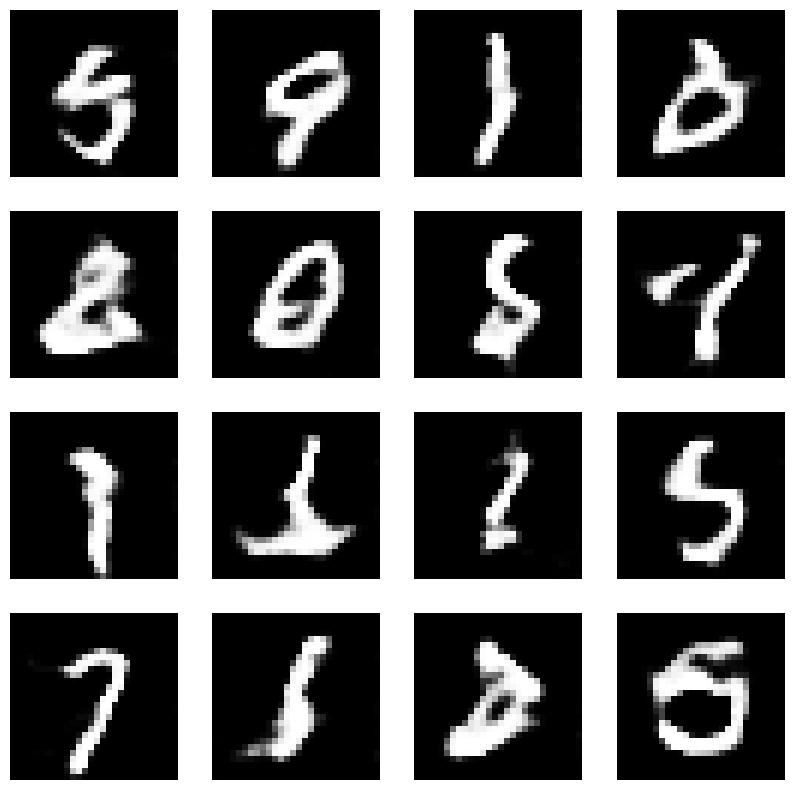

epoch finished ->   54


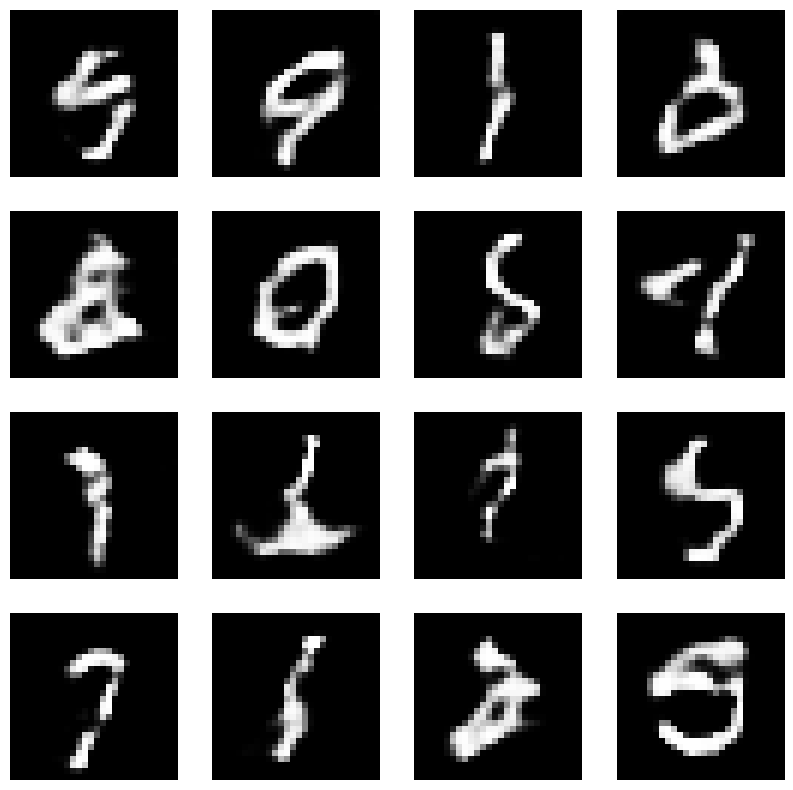

epoch finished ->   55


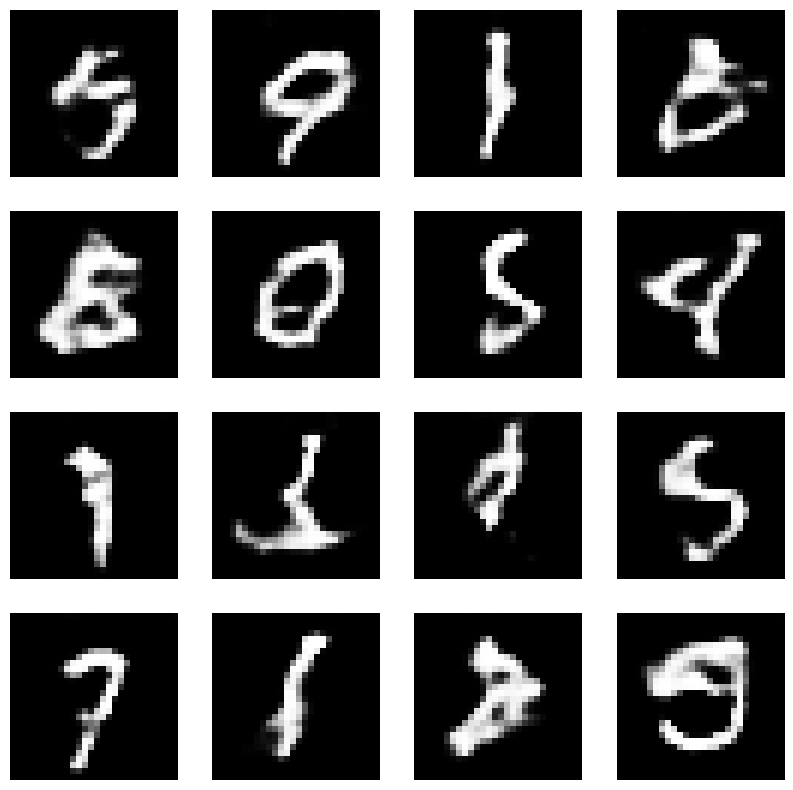

epoch finished ->   56


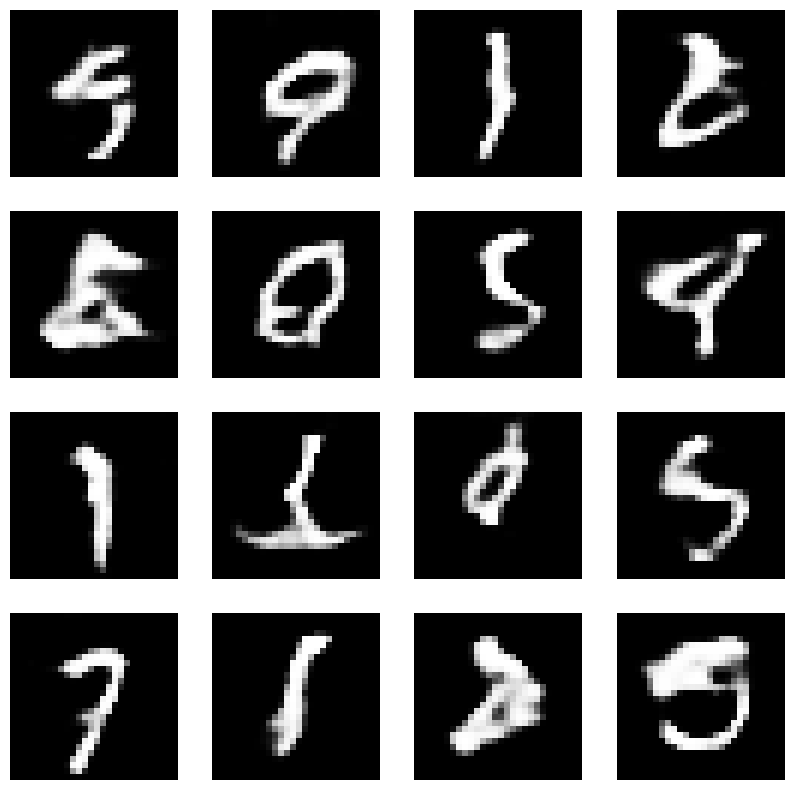

epoch finished ->   57


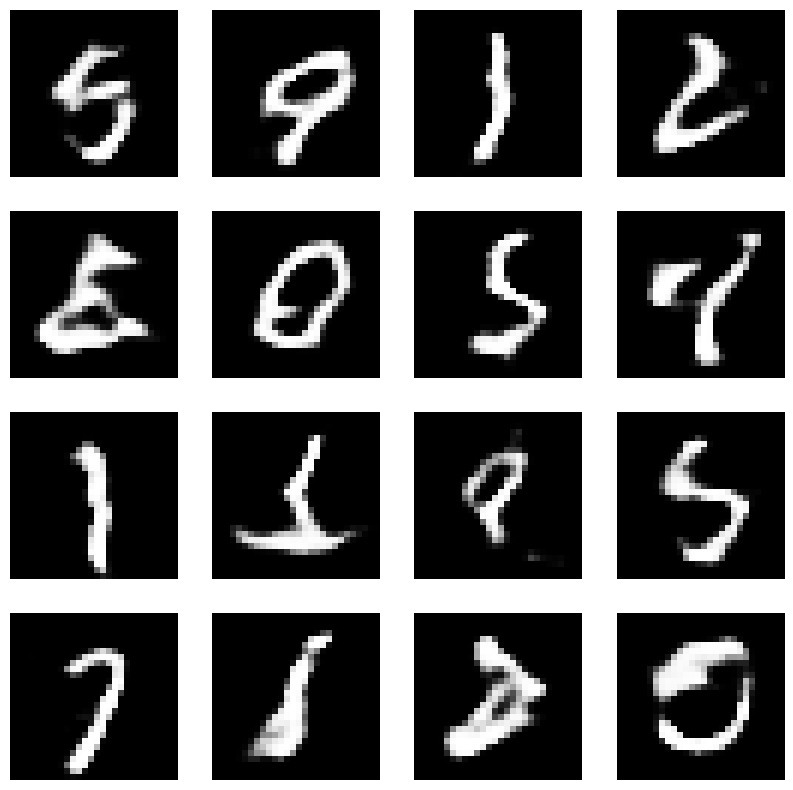

epoch finished ->   58


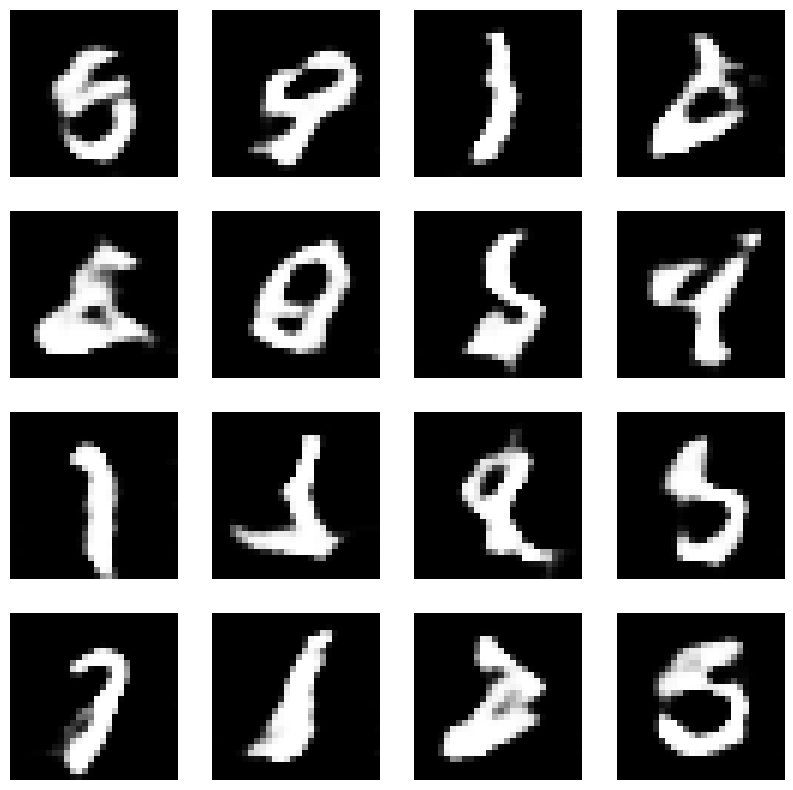

epoch finished ->   59


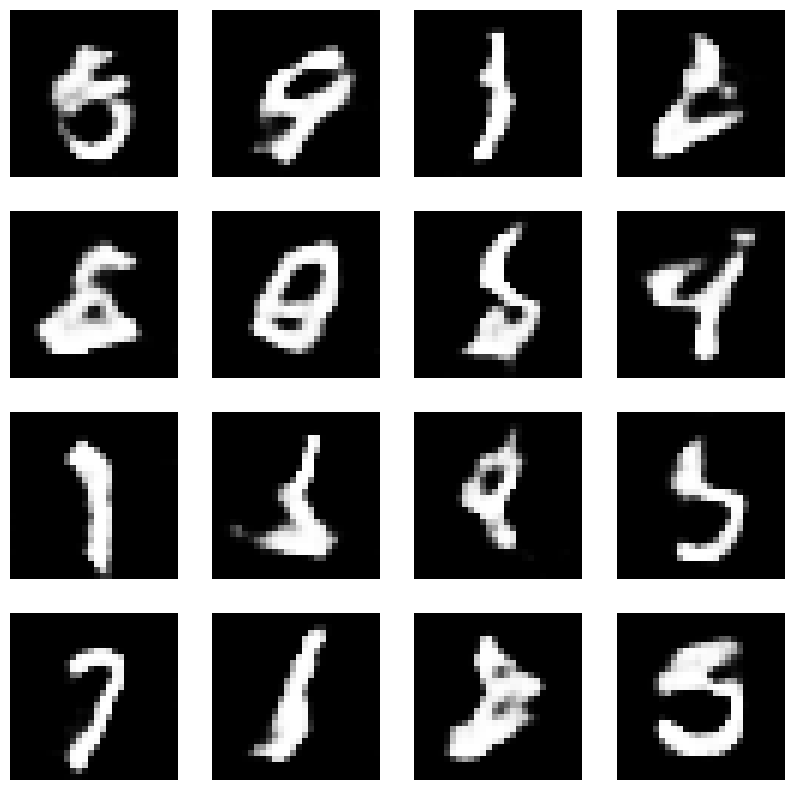

epoch finished ->   60


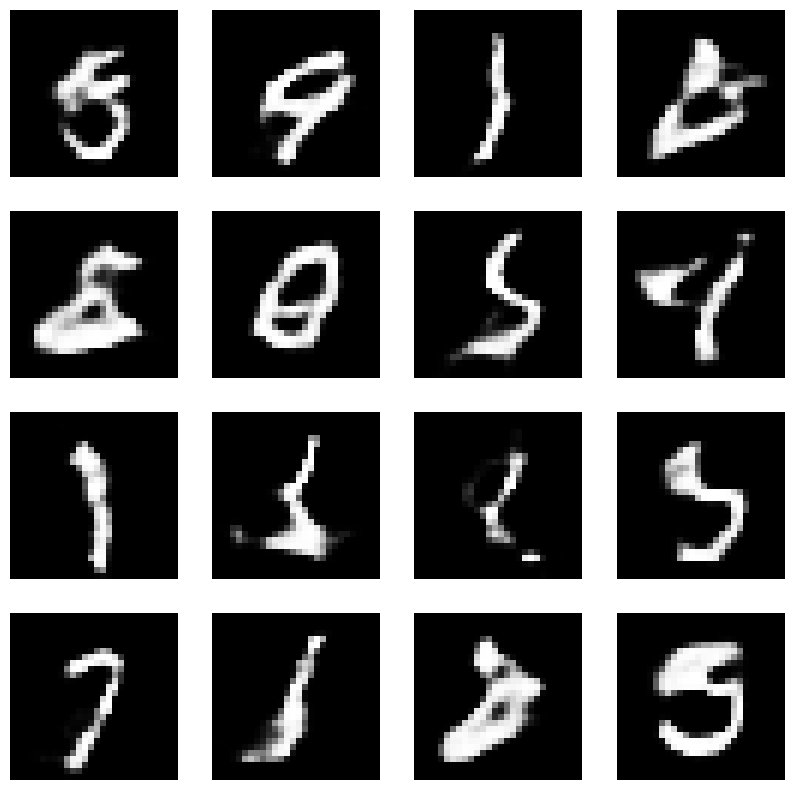

epoch finished ->   61


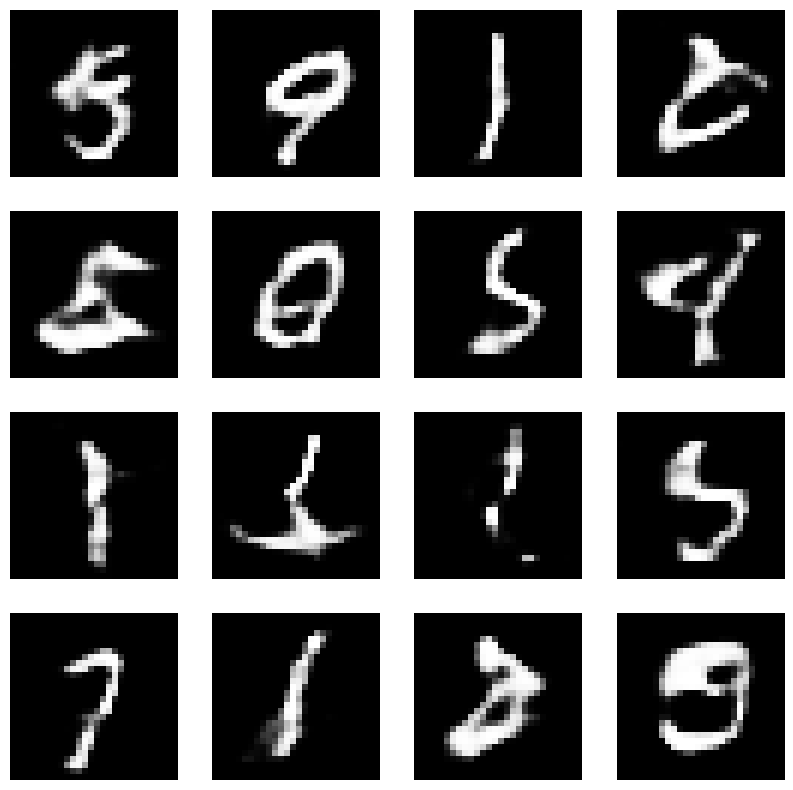

epoch finished ->   62


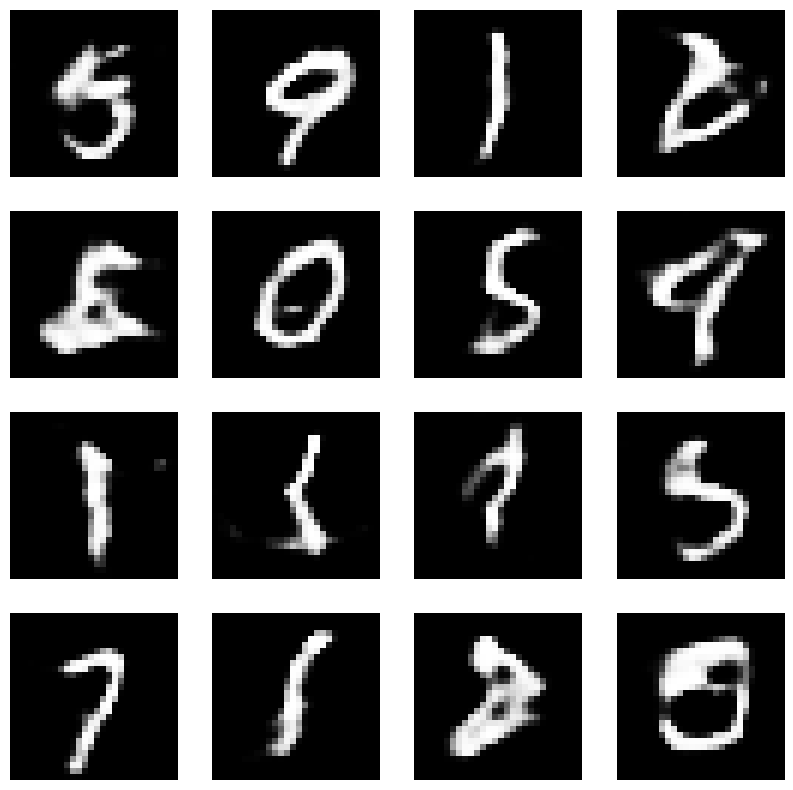

epoch finished ->   63


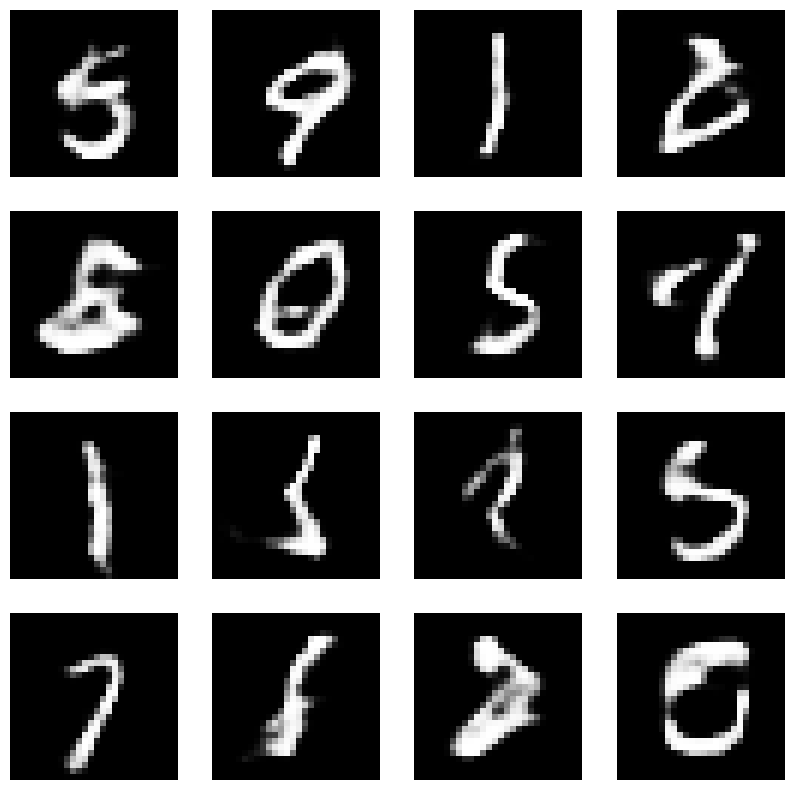

epoch finished ->   64


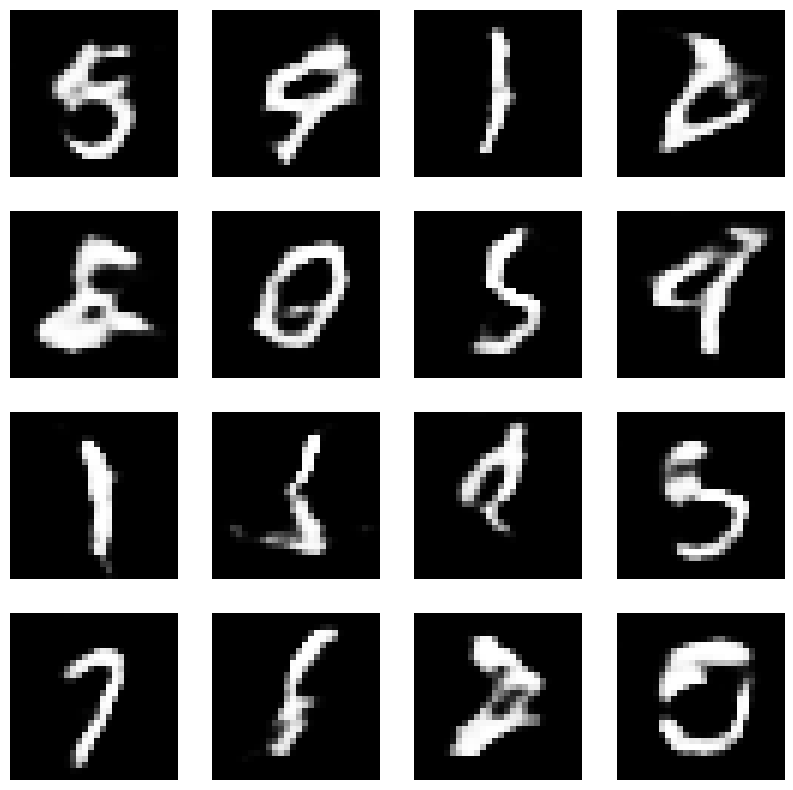

epoch finished ->   65


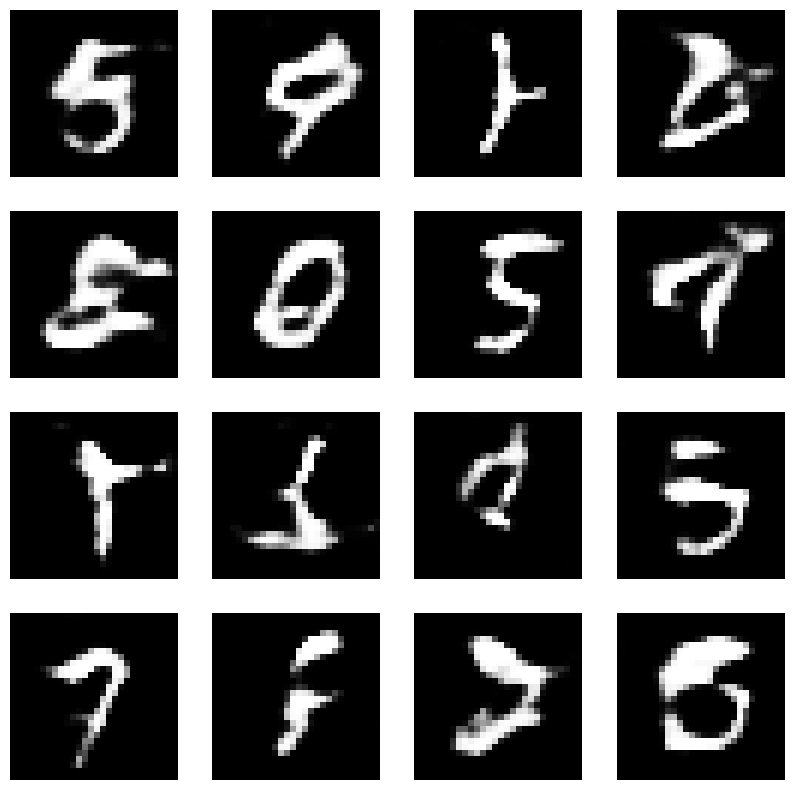

epoch finished ->   66


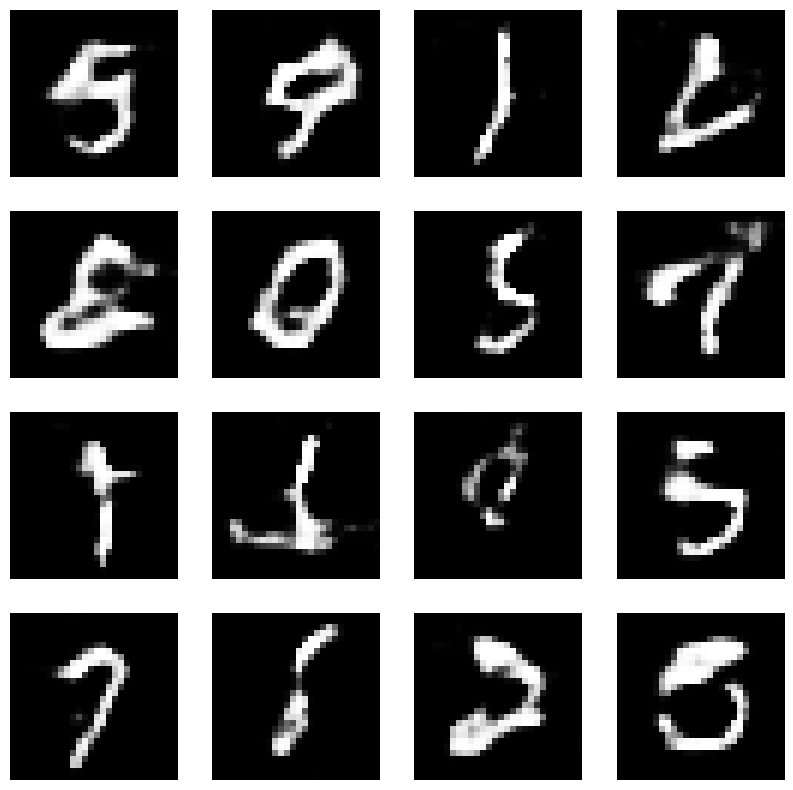

epoch finished ->   67


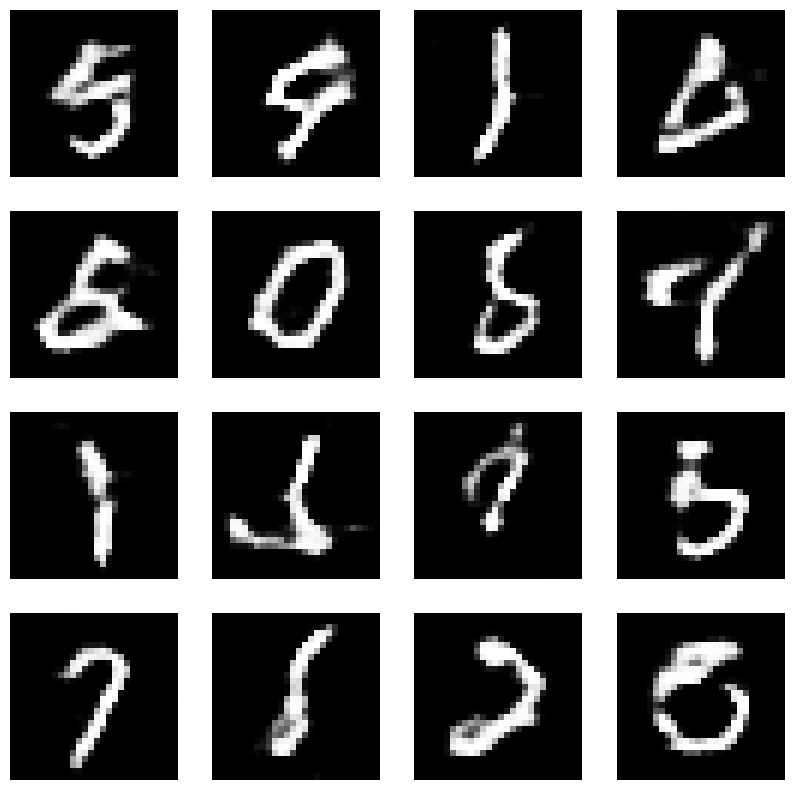

epoch finished ->   68


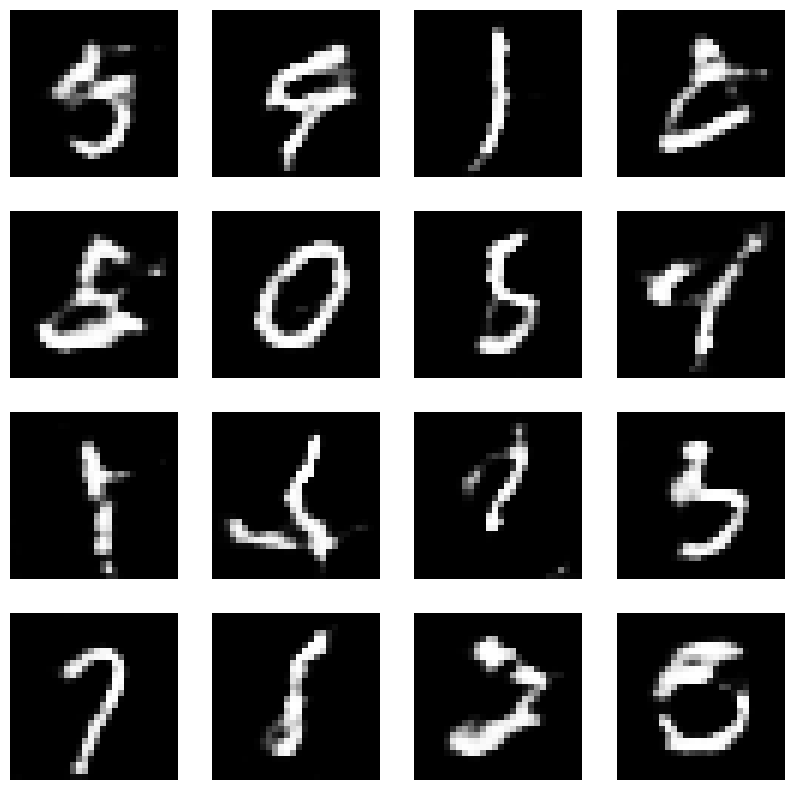

epoch finished ->   69


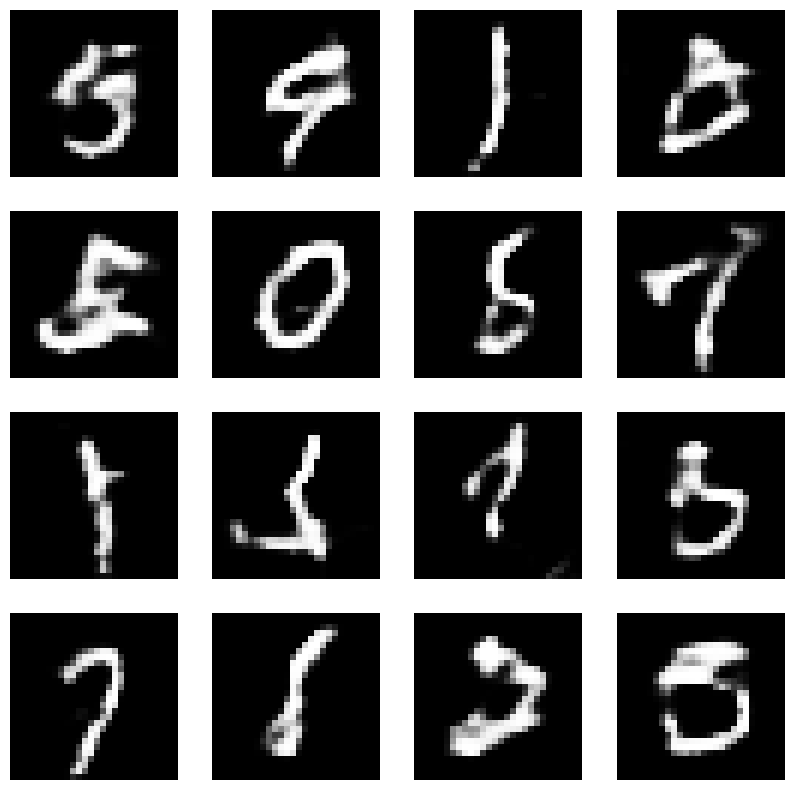

epoch finished ->   70


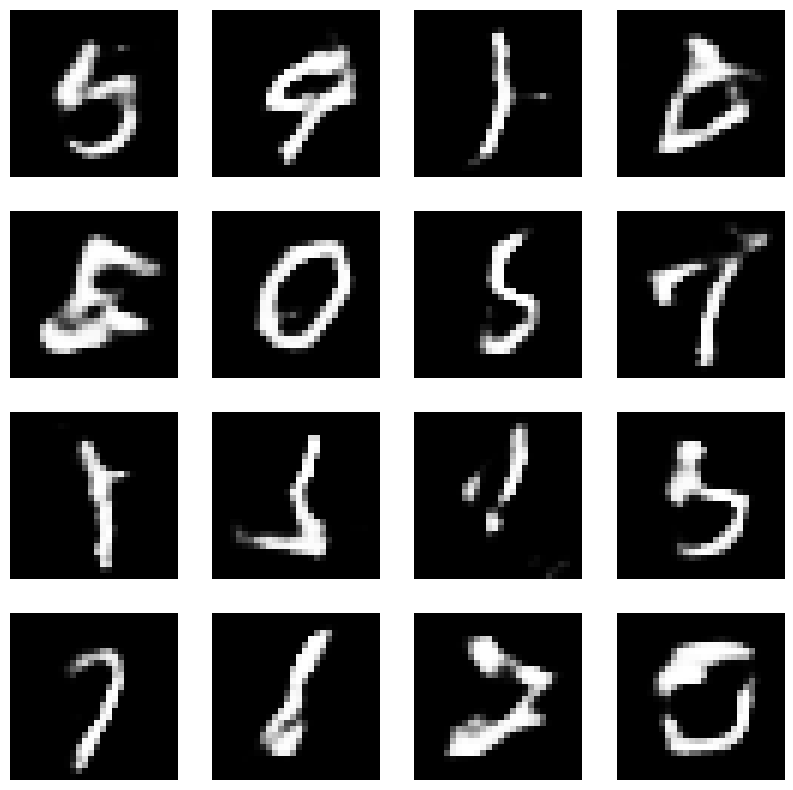

epoch finished ->   71


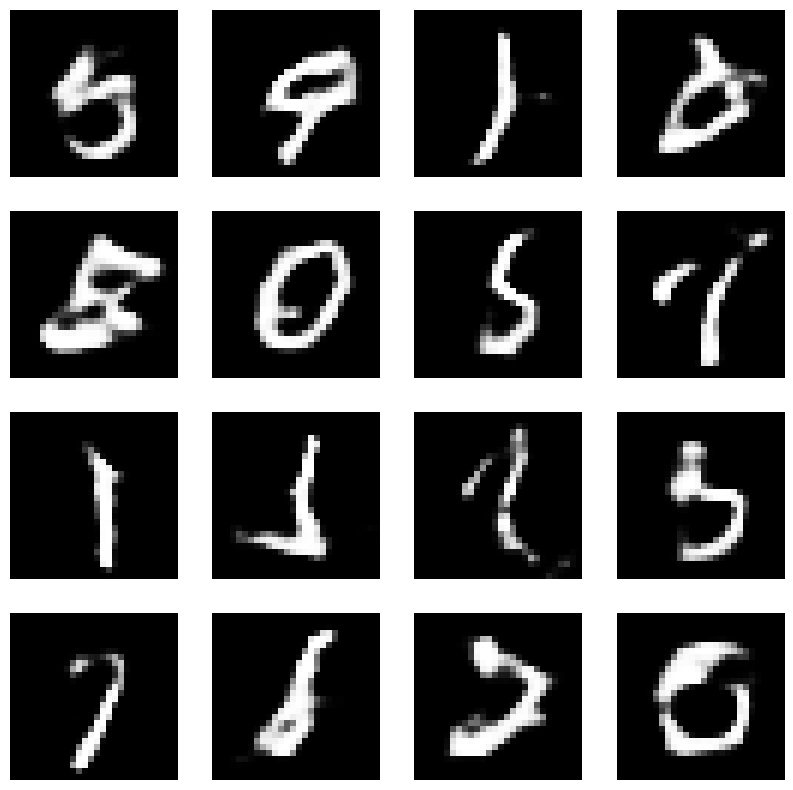

epoch finished ->   72


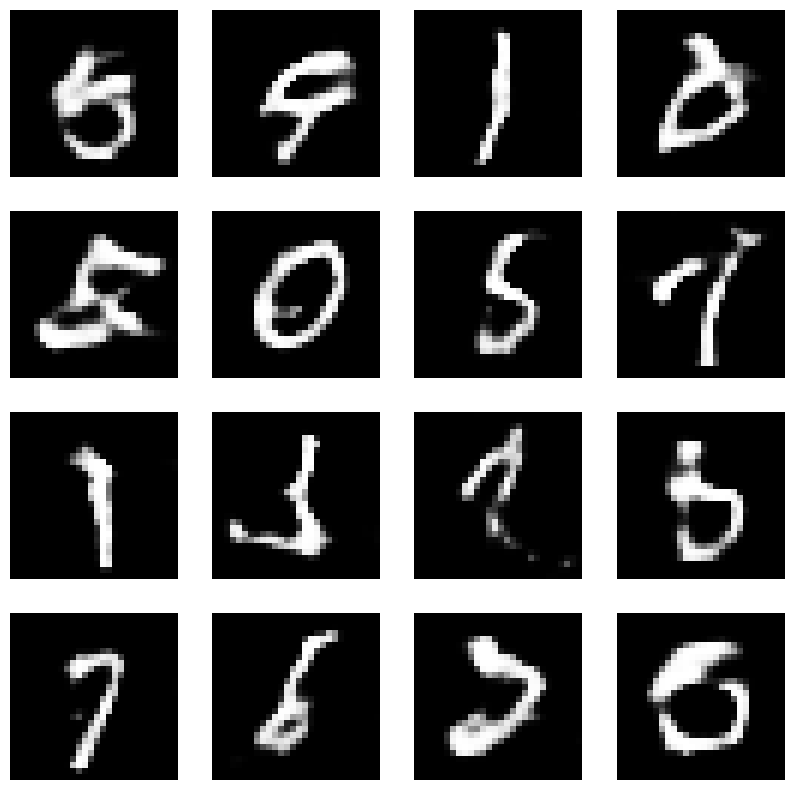

epoch finished ->   73


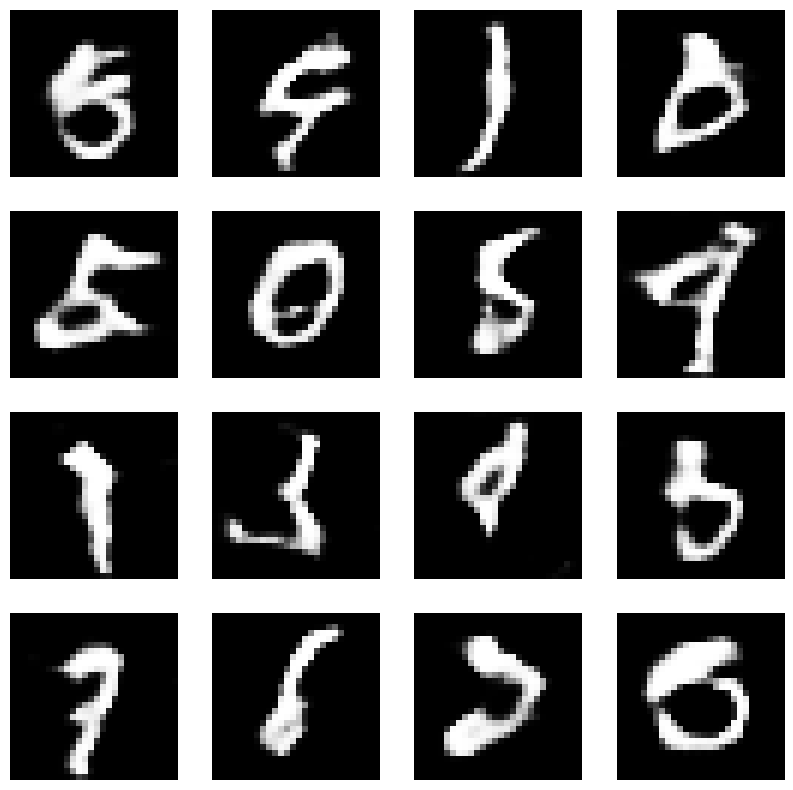

epoch finished ->   74


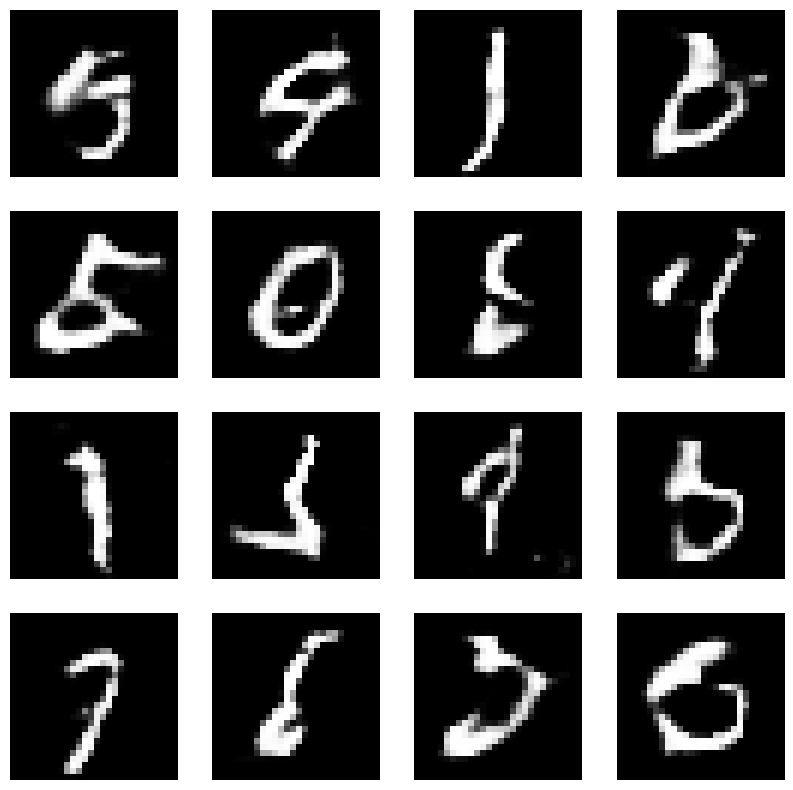

epoch finished ->   75


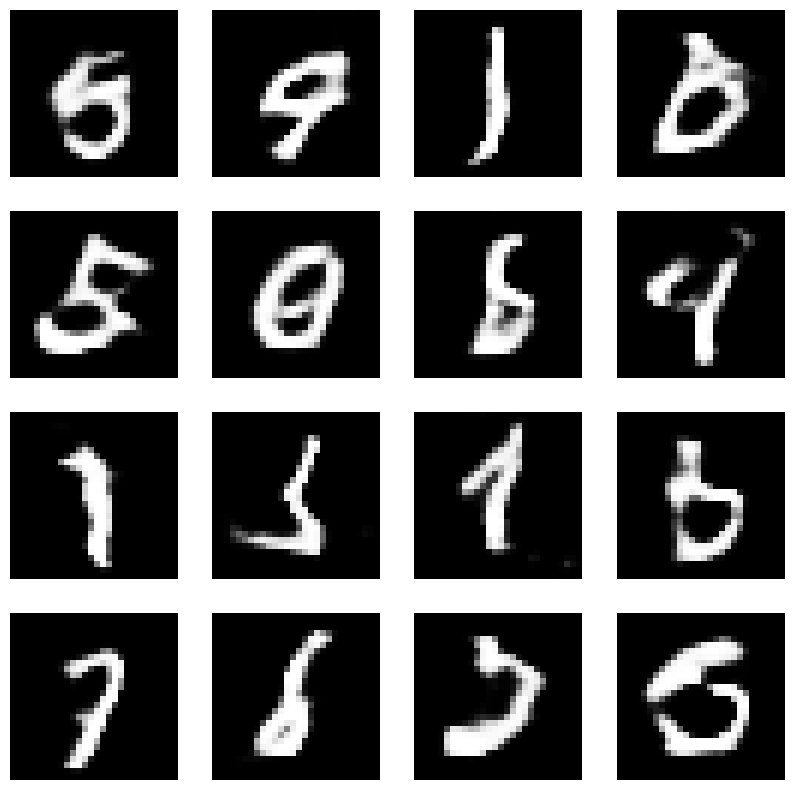

epoch finished ->   76


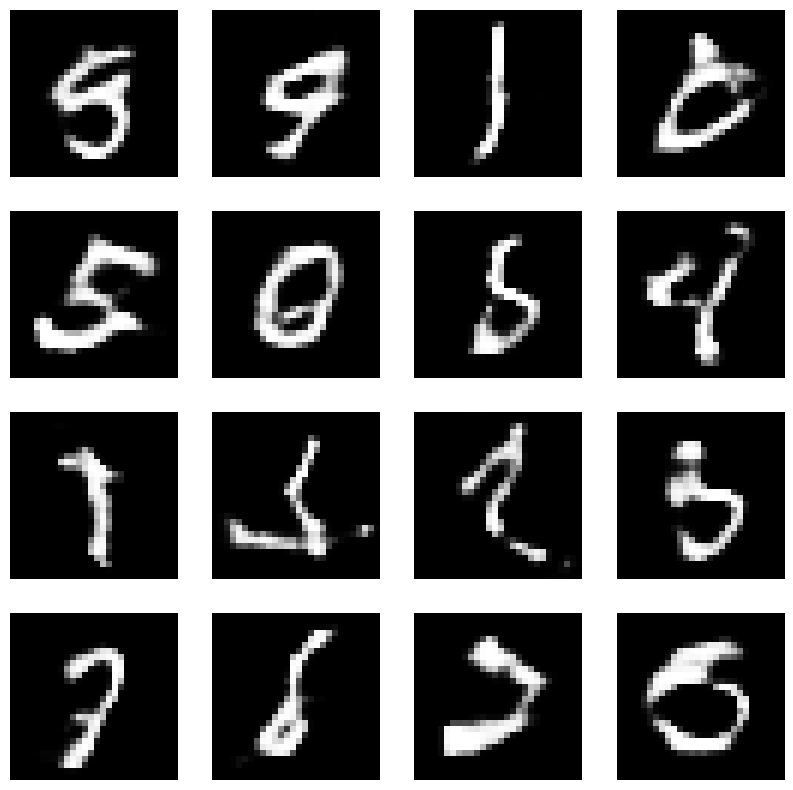

epoch finished ->   77


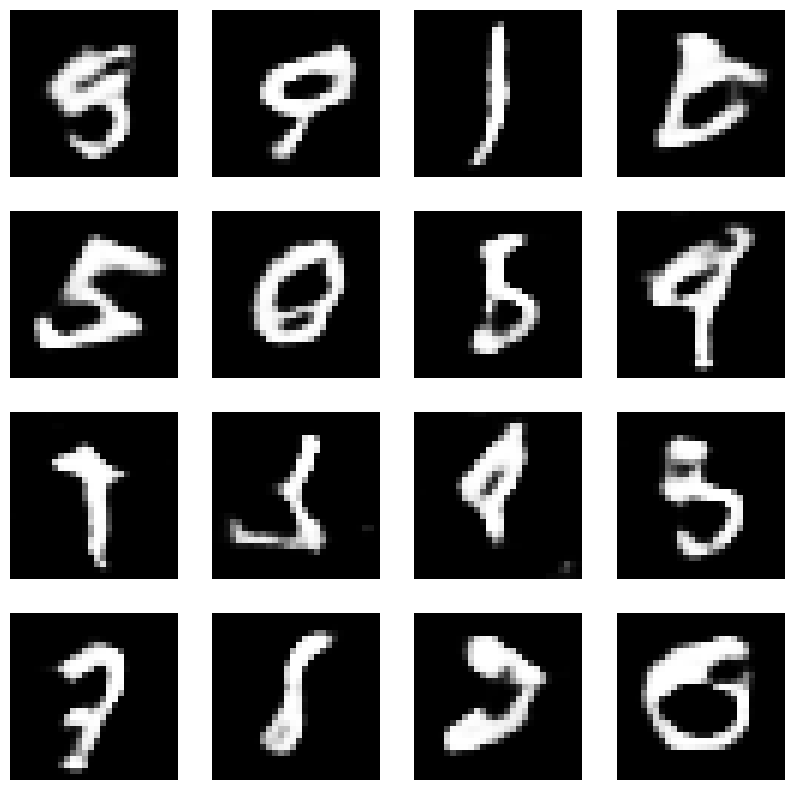

epoch finished ->   78


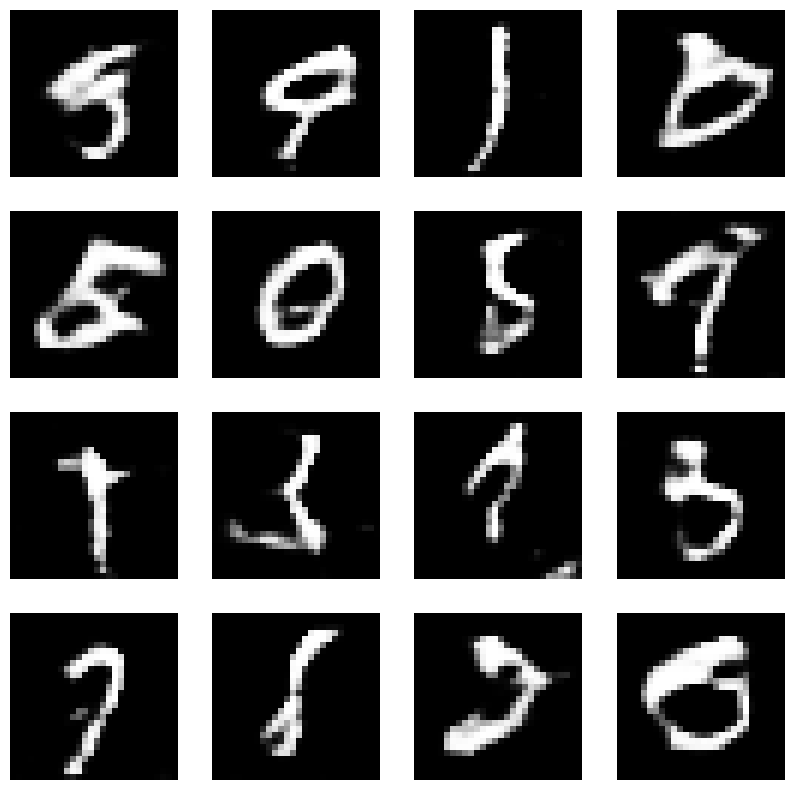

epoch finished ->   79


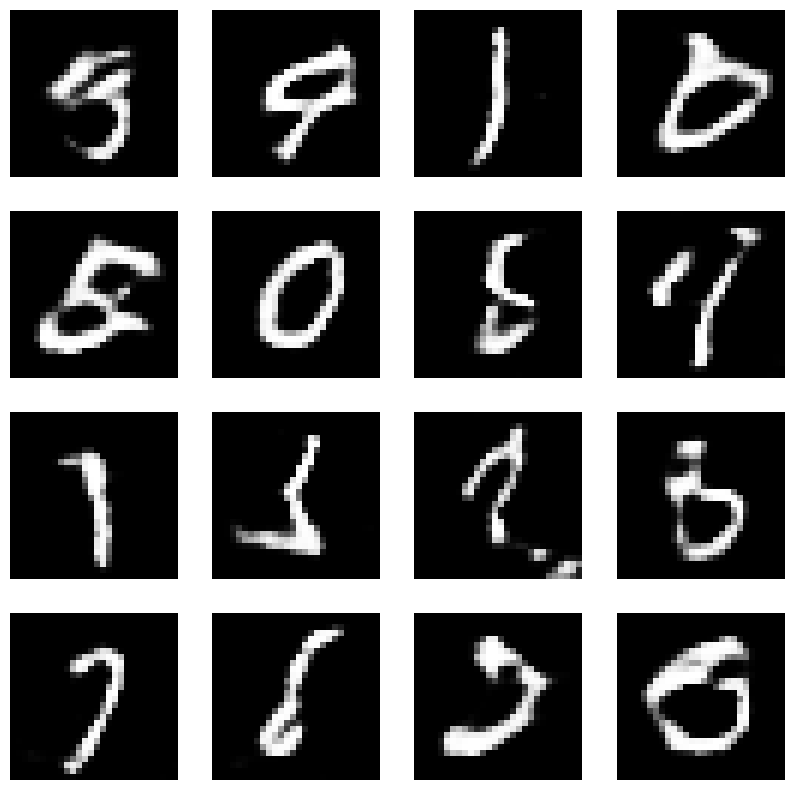

epoch finished ->   80


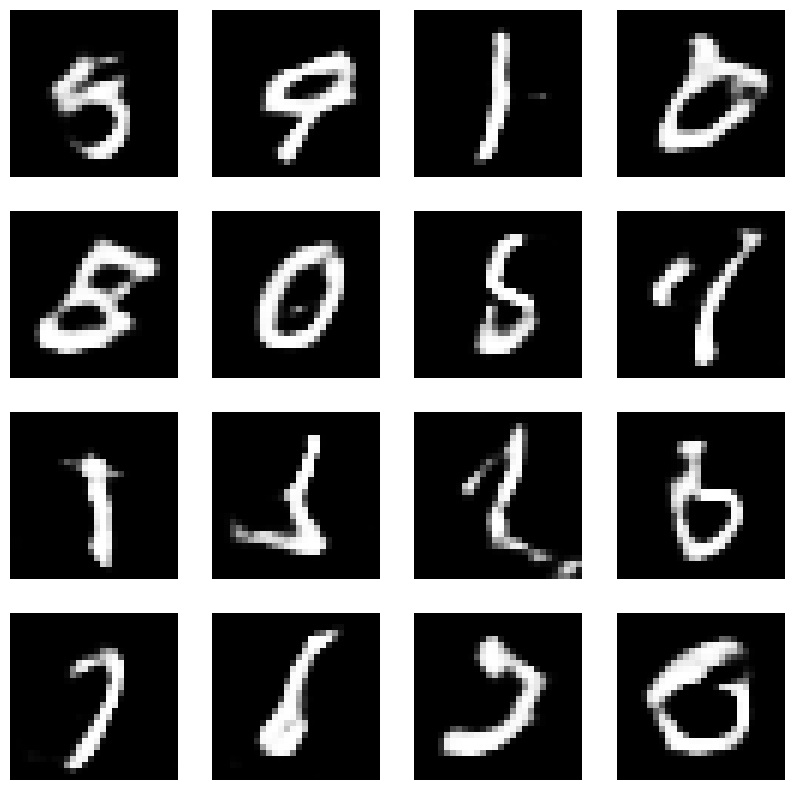

epoch finished ->   81


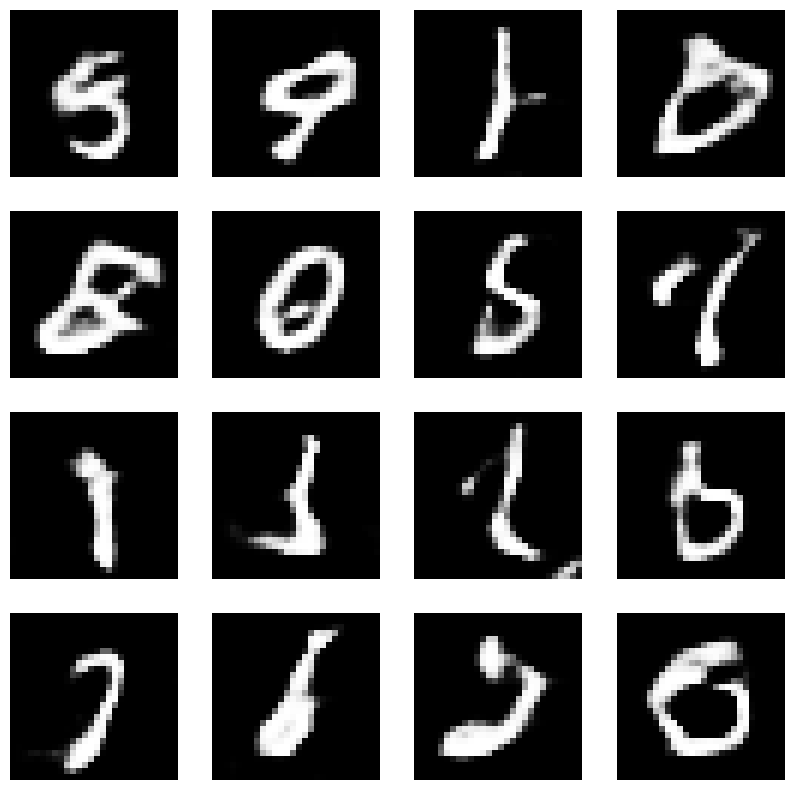

epoch finished ->   82


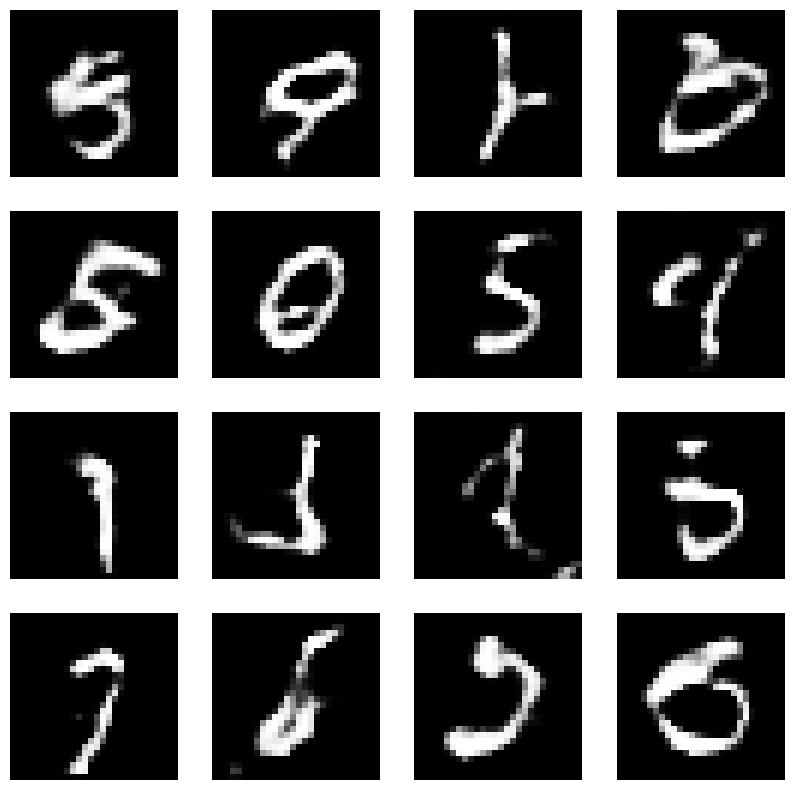

epoch finished ->   83


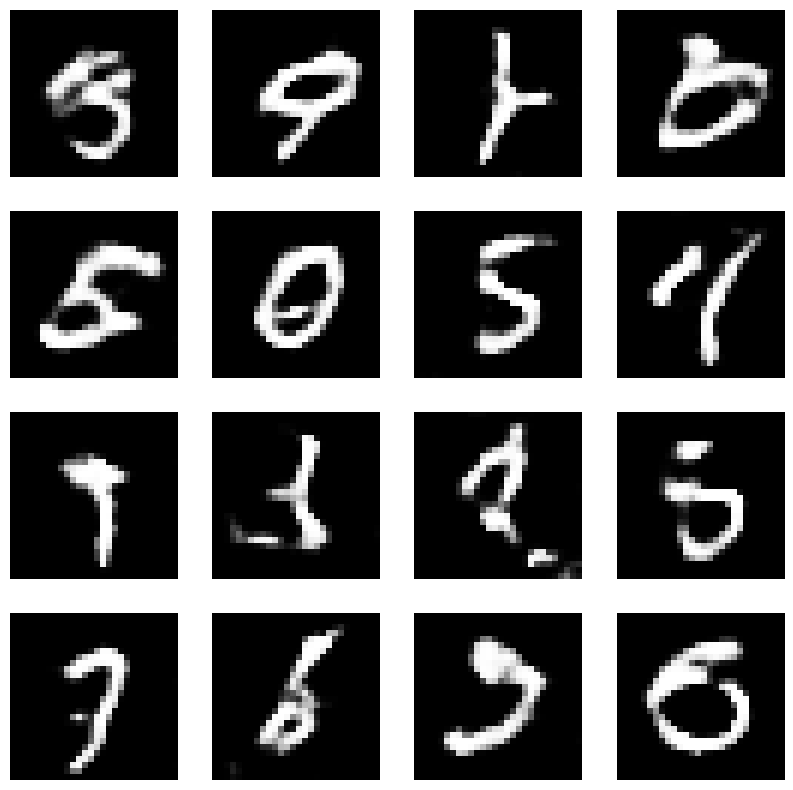

epoch finished ->   84


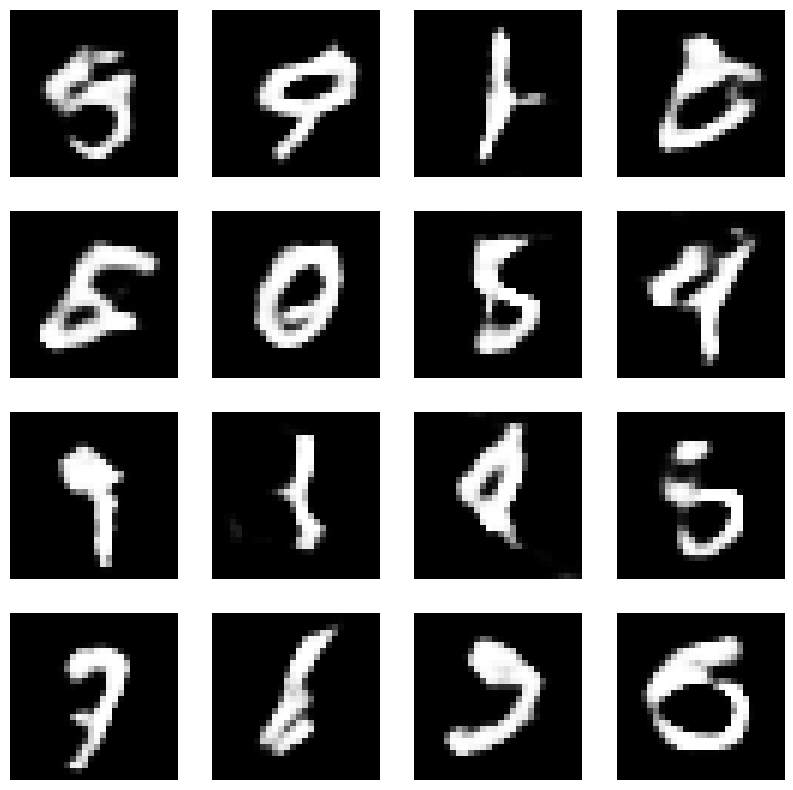

epoch finished ->   85


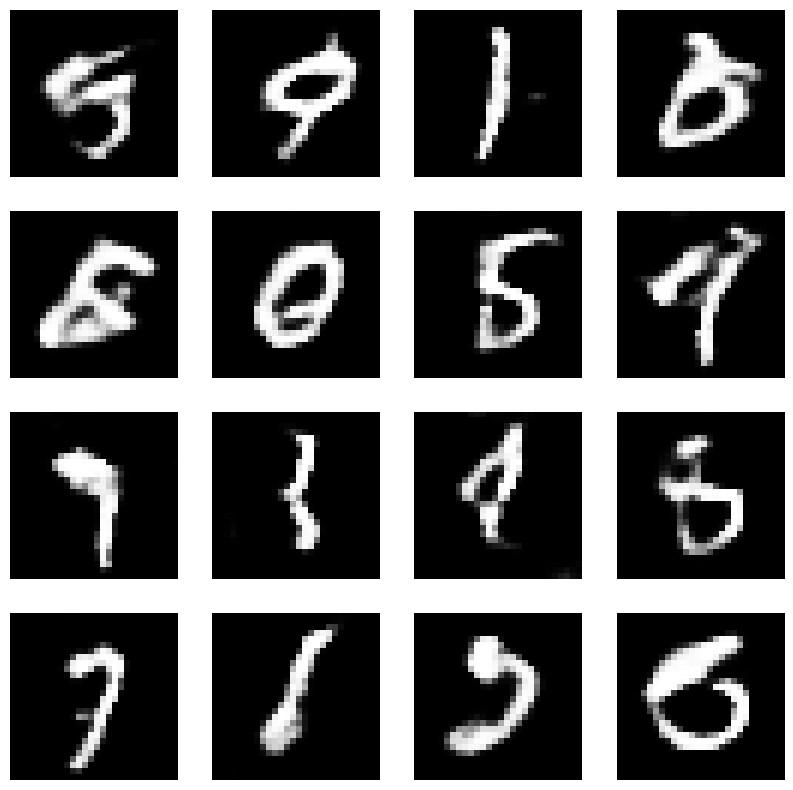

epoch finished ->   86


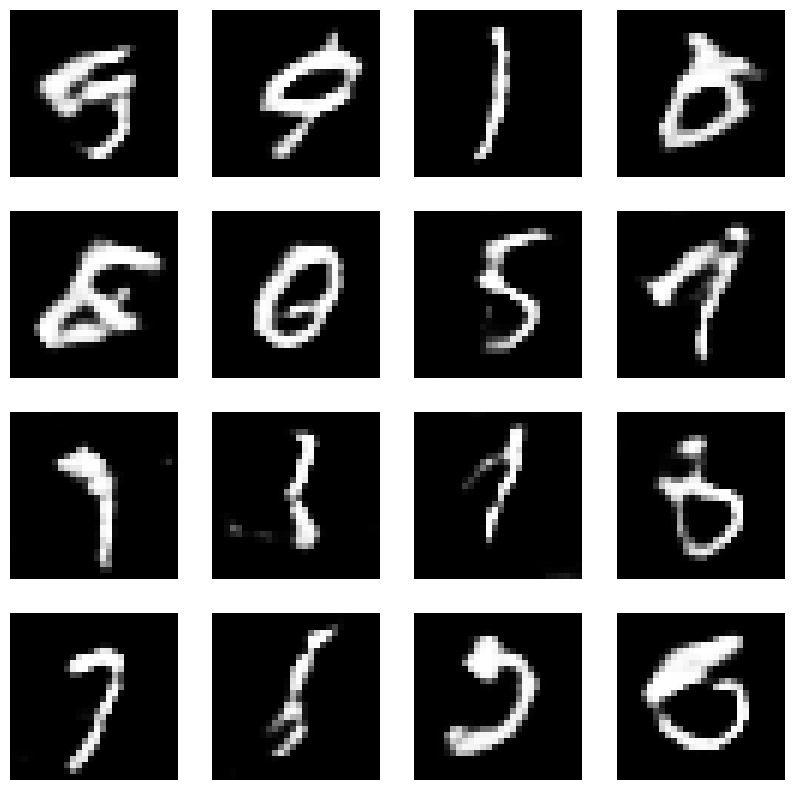

epoch finished ->   87


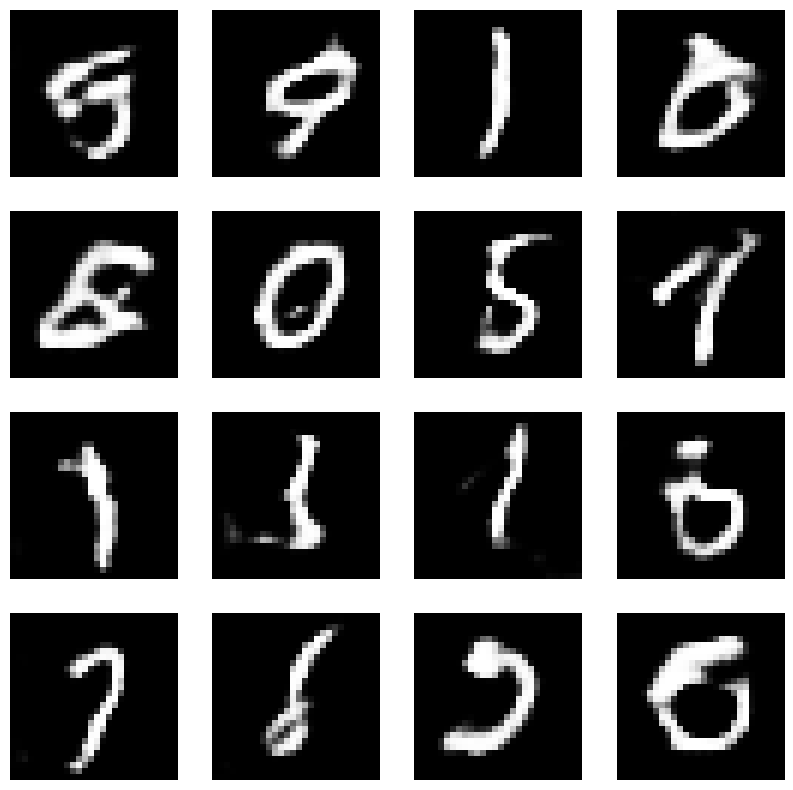

epoch finished ->   88


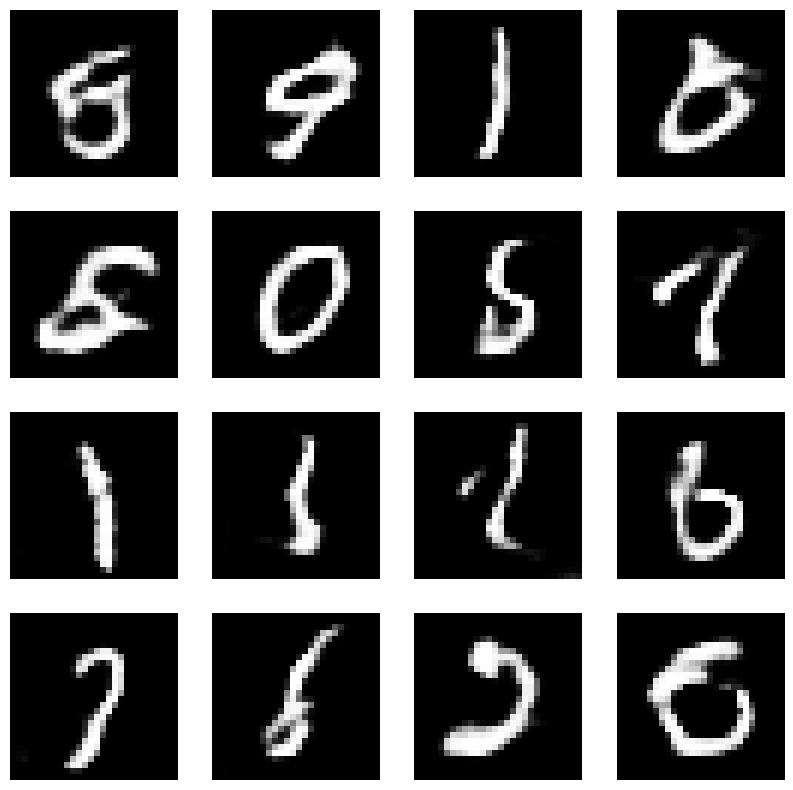

epoch finished ->   89


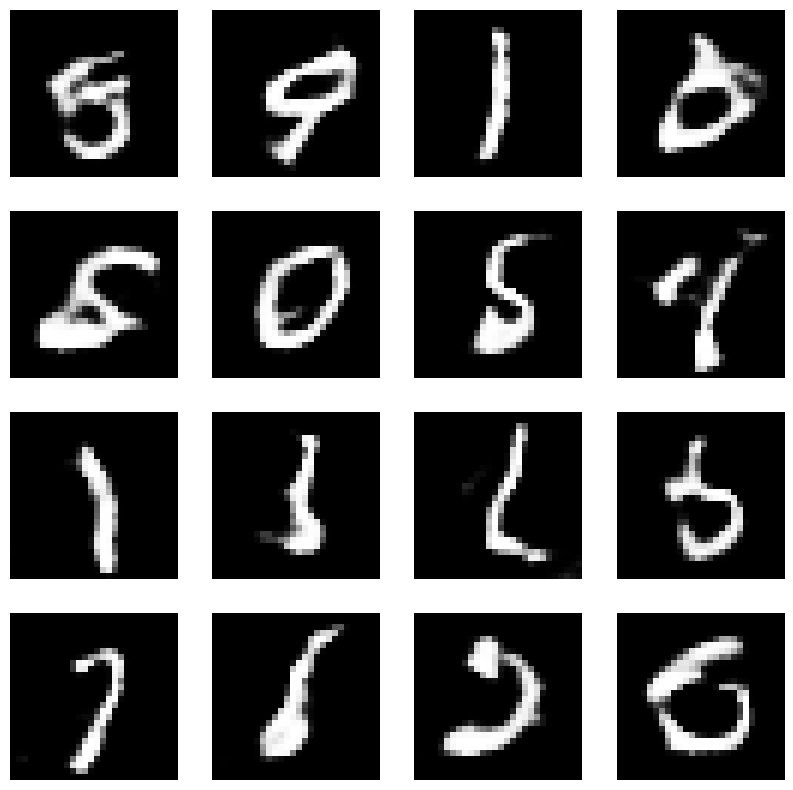

epoch finished ->   90


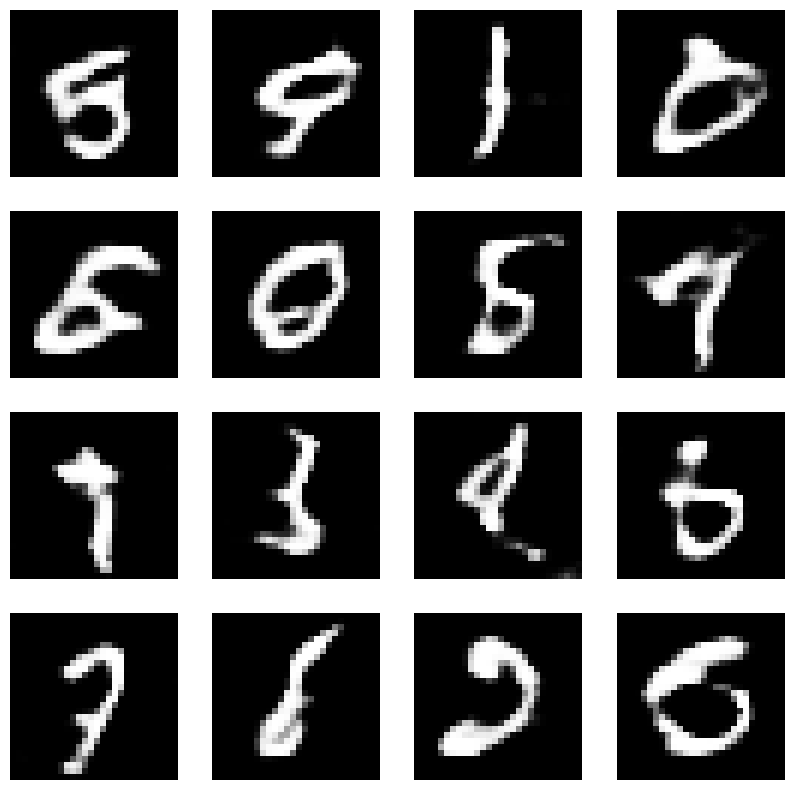

epoch finished ->   91


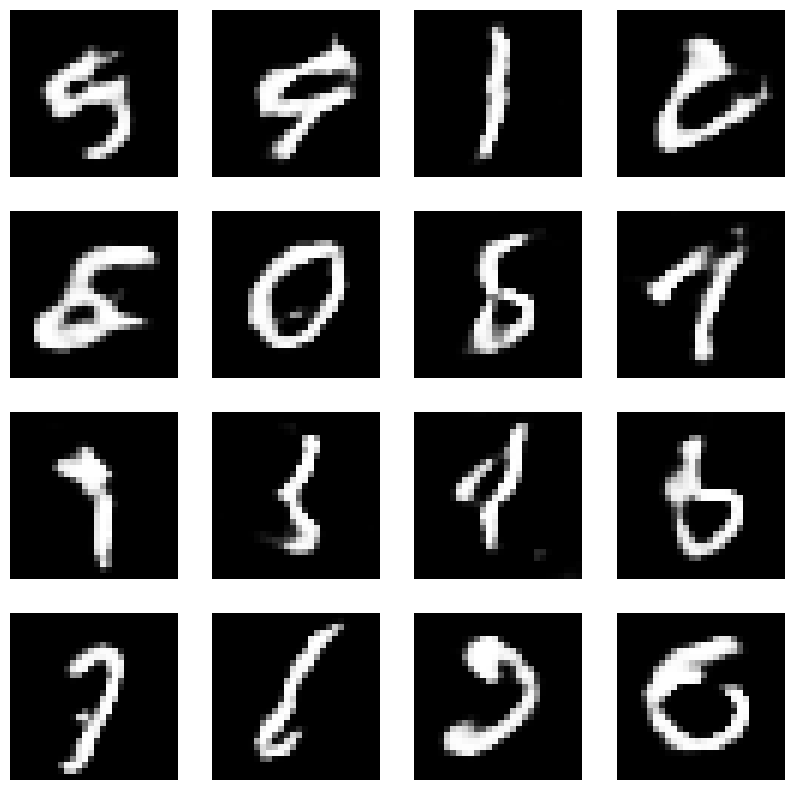

epoch finished ->   92


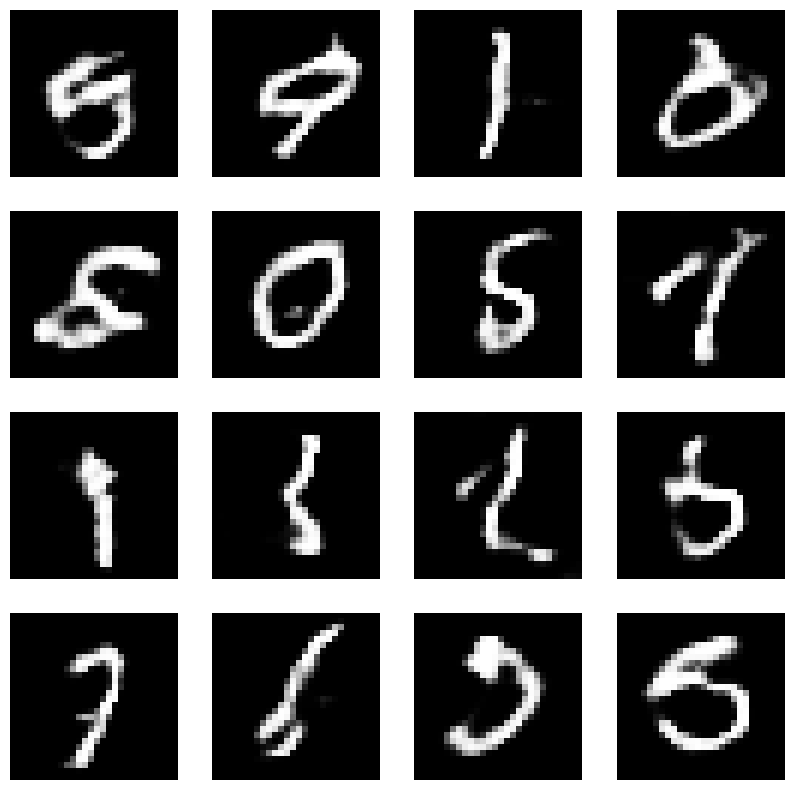

epoch finished ->   93


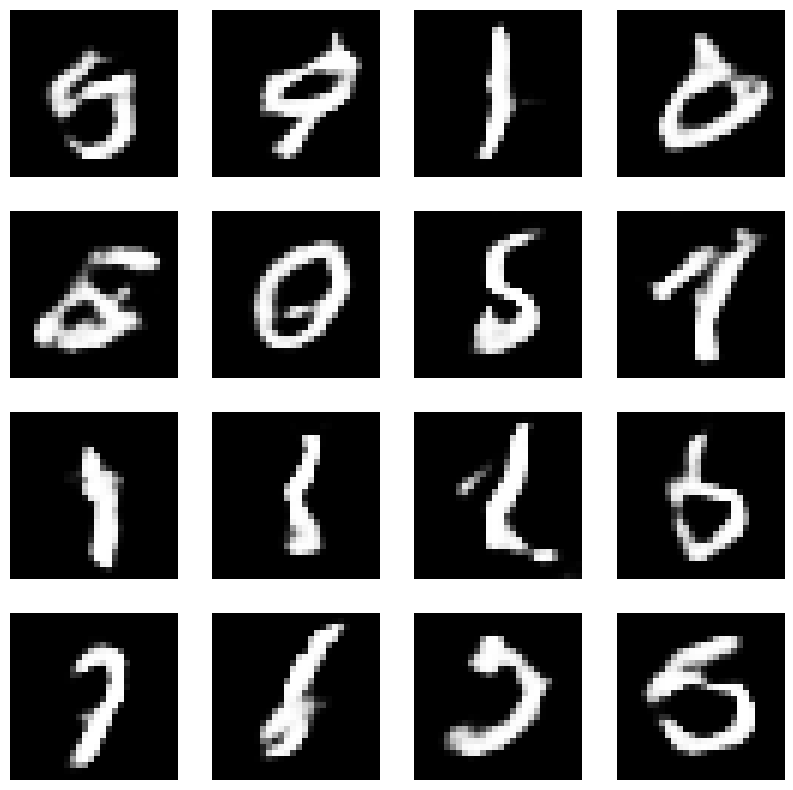

epoch finished ->   94


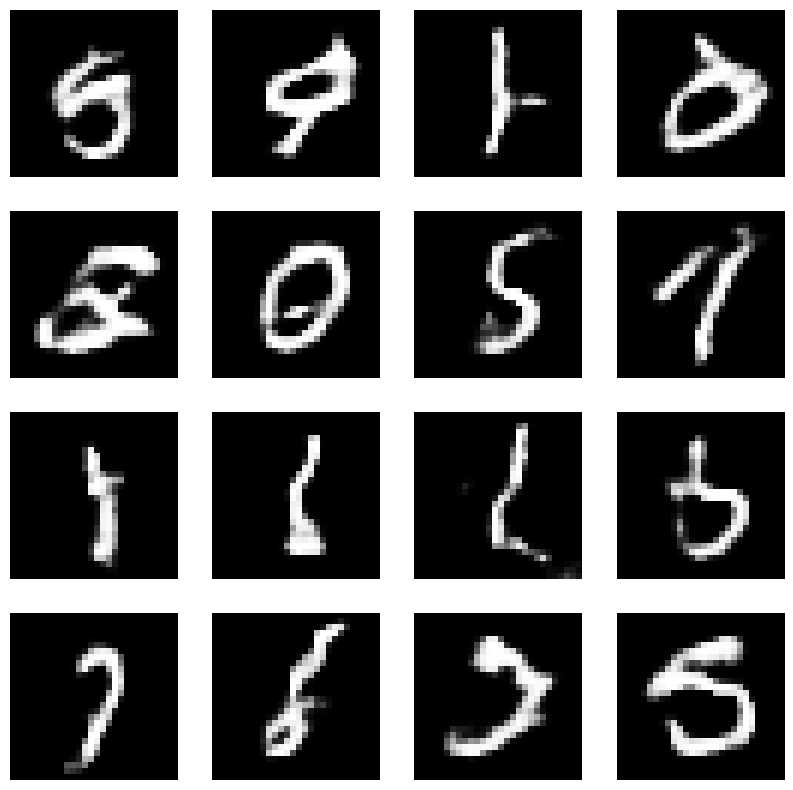

epoch finished ->   95


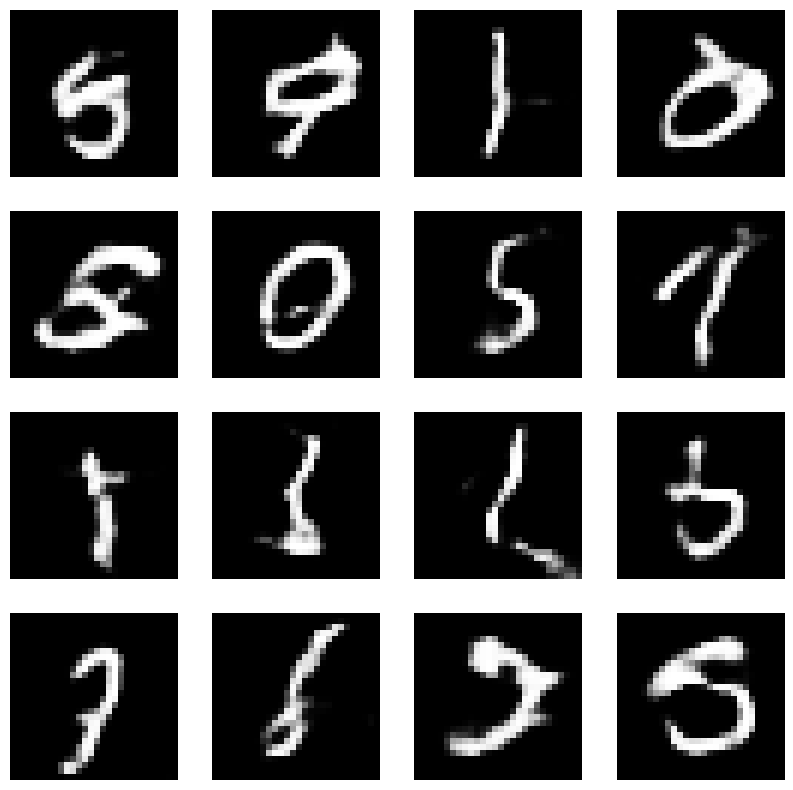

epoch finished ->   96


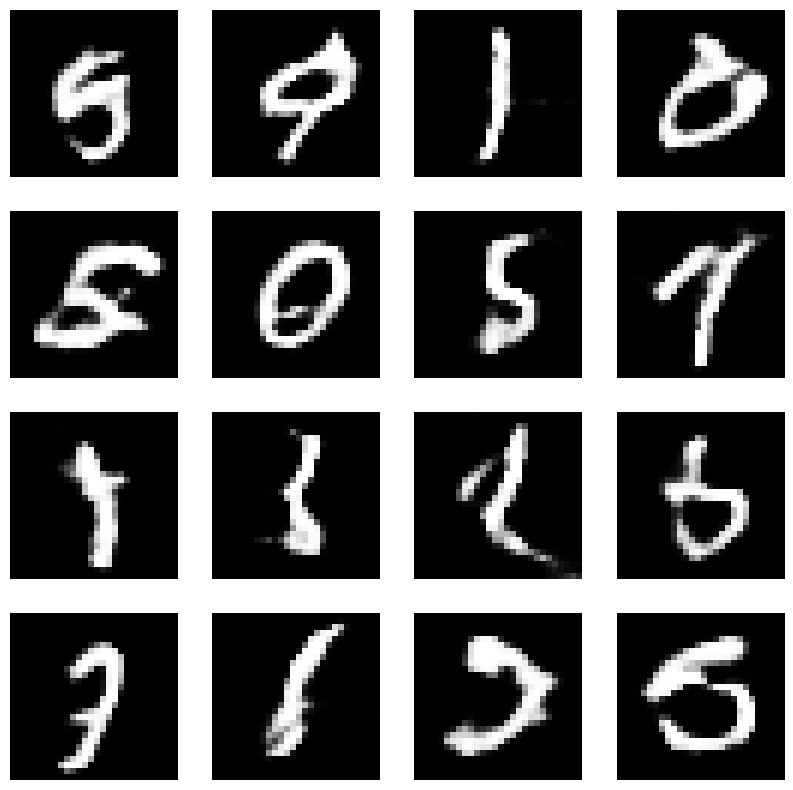

epoch finished ->   97


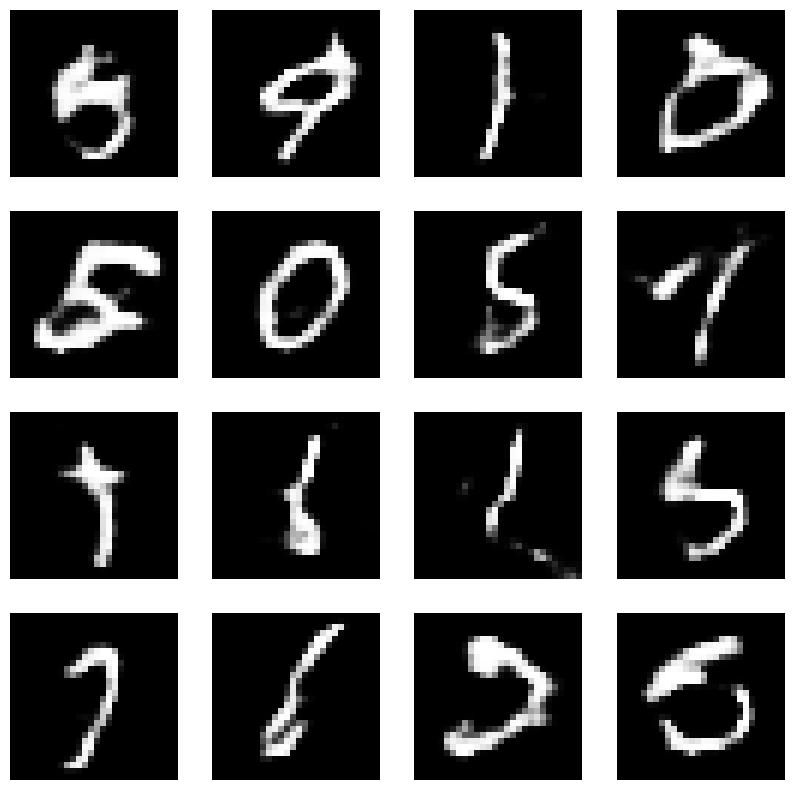

epoch finished ->   98


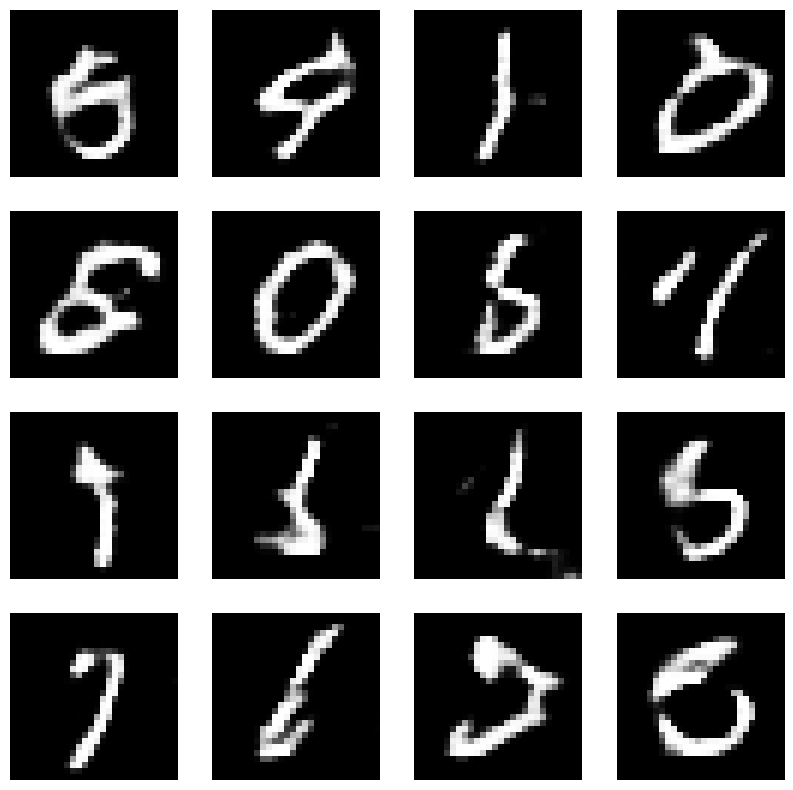

epoch finished ->   99


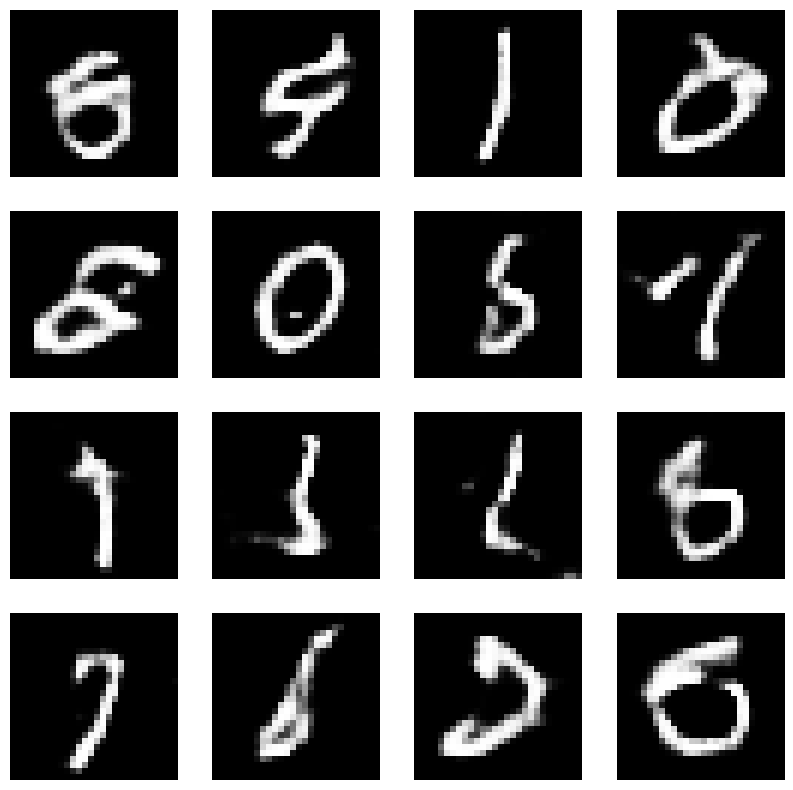

epoch finished ->   100


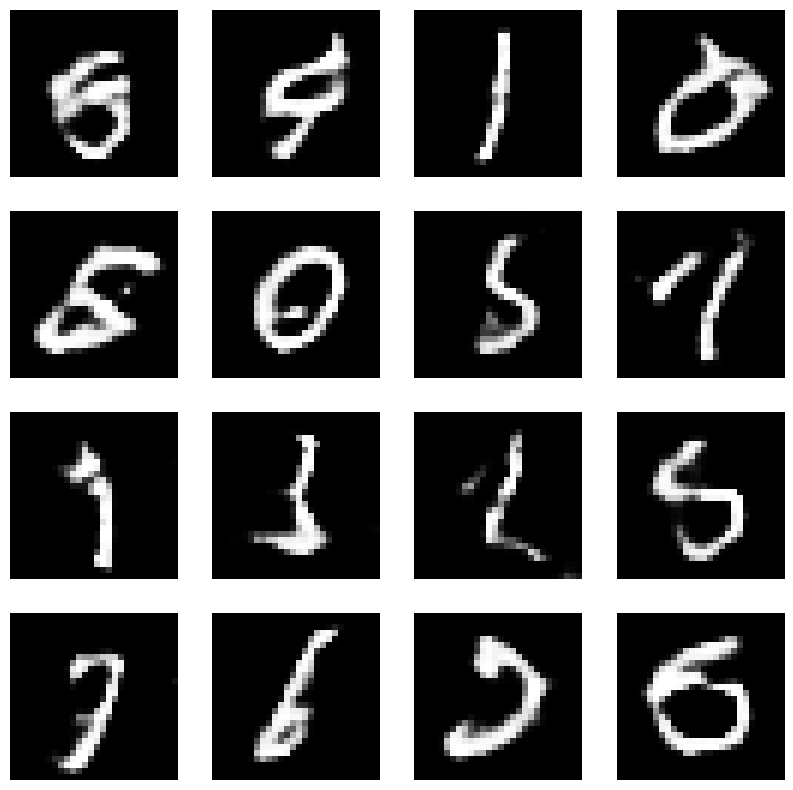

In [ ]:
train(x_train,epochs,test_images)